In [ ]:
import configparser
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import SimpleITK as sitk
import pydicom
from skimage import feature
from radiomics import imageoperations
from scipy import ndimage as ndi
from scipy.ndimage import binary_erosion
import radiomics
from radiomics import featureextractor
from collections import OrderedDict
from scipy.stats import levene
from scipy import stats

import logging

import warnings

pd.set_option('display.max_columns', None)
seed = 100
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
logging.basicConfig(level=logging.CRITICAL)
%matplotlib inline

# Utils

In [146]:
sns.set_style('darkgrid')

In [147]:
def plot_gr_bars(dataframe, columns, label_y, title, rotation=0):
    counts = dataframe.groupby(columns).size().unstack(fill_value=0)
    counts.plot(kind='bar', stacked=True)

    plt.title(title)
    plt.ylabel('Number of '+label_y)
    plt.xticks(rotation=rotation)
    plt.show()

In [148]:
def plot_bars(dataframe, columns, label_y, title, rotation=0, max_cols=3):
    num_plots = len(columns)
    num_rows = (num_plots + max_cols - 1) // max_cols 
    
    fig, axes = plt.subplots(num_rows, max_cols, figsize=(max_cols*5, num_rows*3), squeeze=False)
    
    for i, column in enumerate(columns):
        ax = axes[i // max_cols, i % max_cols]
        counts = dataframe[column].value_counts()
        counts.plot(kind='bar', ax=ax)
        ax.set_xlabel(column)
        ax.set_ylabel('Number of '+label_y)
        ax.set_xticklabels(counts.index, rotation=rotation)
        
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    # Remove extra subplots
    for j in range(i + 1, num_rows * max_cols):
        fig.delaxes(axes.flatten()[j])
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [153]:
def plot_combined_bars(df1, df2, columns, label_y, title, rotation=0, max_cols=3):
    num_plots = len(columns)
    num_rows = (num_plots + max_cols - 1) // max_cols 

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(max_cols*6, num_rows*4), squeeze=False)

    for i, column in enumerate(columns):
        ax = axes[i // max_cols, i % max_cols]
    
        counts1 = df1[column].value_counts()
        counts2 = df2[column].value_counts()

        combined_counts = pd.DataFrame({'Train': counts1, 'Validation': counts2})

        combined_counts['Total'] = combined_counts.sum(axis=1)
        combined_counts = combined_counts.sort_values(by='Total', ascending=False)

        combined_counts[['Train', 'Validation']].plot(kind='bar', ax=ax)

        ax.set_xlabel(column)
        ax.set_ylabel('Number of ' + label_y)
        ax.set_xticklabels(combined_counts.index, rotation=rotation)

        for p in ax.patches:
            ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    for j in range(i + 1, num_rows * max_cols):
        fig.delaxes(axes.flatten()[j])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [154]:
def plot_combined_bars3(df_1, df_2, df_3, columns, label_y, title, rotation=0, max_cols=3):
    num_plots = len(columns)
    num_rows = (num_plots + max_cols - 1) // max_cols 

    label_map = {0: 'Controls', 1: 'Cases'}
    df1 = df_1.copy()
    df2 = df_2.copy()
    df3 = df_3.copy()
    
    df1['Label'] = df1['Label'].map(label_map)
    df2['Label'] = df2['Label'].map(label_map)
    df3['Label'] = df3['Label'].map(label_map)
    fig, axes = plt.subplots(num_rows, max_cols, figsize=(max_cols*6, num_rows*4), squeeze=False)

    for i, column in enumerate(columns):
        ax = axes[i // max_cols, i % max_cols]
        ax.set_ylim(0, 360)
        counts1 = df1[column].value_counts()
        counts2 = df2[column].value_counts()
        counts3 = df3[column].value_counts()  

        combined_counts = pd.DataFrame({'Both': counts1, 'FGR': counts2, 'PE': counts3}) 

        combined_counts['Total'] = combined_counts.sum(axis=1)
        combined_counts = combined_counts.sort_values(by='Total', ascending=False)

        combined_counts[['Both', 'FGR', 'PE']].plot(kind='bar', ax=ax) 

        ax.set_xlabel(column)
        ax.set_ylabel('Number of ' + label_y)
        ax.set_xticklabels(combined_counts.index, rotation=rotation)

        for p in ax.patches:
            ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    for j in range(i + 1, num_rows * max_cols):
        fig.delaxes(axes.flatten()[j])

    plt.title(title)
    plt.tight_layout()
    plt.show()

In [155]:
def boxplot_pixel_spacing(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.boxplot(x=df['Pixel spacing x'], ax=ax1)
    sns.boxplot(x=df['Pixel spacing y'], ax=ax2)
    plt.tight_layout()
    plt.show()

In [156]:
def get_mask_example(path):
    mask_image = plt.imread(path).astype(np.uint8)
    if len(mask_image.shape) == 3:
        mask_image = cv2.cvtColor(mask_image, cv2.COLOR_RGB2GRAY)
    
    return mask_image
  
def get_image_example(path):
    dicom_image = pydicom.dcmread(path)
    image_data =  cv2.cvtColor(dicom_image.pixel_array, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    
    return image_data

In [157]:
def show_image_stadistics(images, boxplot=False):
    
    def gl_statistics(_image):
        return { 'Maximum': np.max(_image),     
                  'Mean': np.mean(_image),
                  'Minimum': np.min(_image)}
    
    min_vals  = []
    max_vals = []
    mean_vals = []
    
    for num, cropped_image in enumerate(images):
        stats = gl_statistics(cropped_image)
        min_vals.append(stats['Minimum'])
        mean_vals.append(stats['Mean'])
        max_vals.append(stats['Maximum'])
        
    print('Minimum '+str(np.min(min_vals)))
    print('Maximum '+str(np.max(max_vals)))
    df_stats=pd.DataFrame({'min': min_vals, 'mean': mean_vals, 'max': max_vals})
  
    plt.figure(figsize=(7, 4))
    plt.scatter(range(len(images)), min_vals, label='Min')
    plt.scatter(range(len(images)), max_vals, label='Max')
    plt.scatter(range(len(images)), mean_vals, label='Mean')
    plt.legend()
    plt.title('Min, Max, and Mean Intensities of ROIs')
    plt.xlabel('ROIs')
    plt.ylabel('Intensity')
    plt.show()
    
    if boxplot:
        plt.figure(figsize=(7, 4))
        df_stats.boxplot(column=['min', 'mean', 'max'])
        plt.title('Intensity ROI level range')
        plt.show()

In [158]:
progress_filename = os.path.join('../data/log.txt')
logger = logging.getLogger('logger')
logger.setLevel(logging.INFO) 
file_handler = logging.FileHandler(progress_filename, mode='w') 
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)     
logger_pyr = logging.getLogger('radiomics')
logger_pyr.addHandler(file_handler)
logger_pyr.setLevel(logging.INFO)

def _dict_to_csv(output_csv, features_dict_list):
    with open(output_csv, mode='w') as outputFile:
        writer = csv.DictWriter(outputFile,
                                fieldnames=list(features_dict_list[0].keys()),
                                restval='',
                                extrasaction='raise',
                                lineterminator='\n')
        writer.writeheader()
        writer.writerows(features_dict_list)

# Dataframe creation with train patients with the completed study
We divide the dataset in two groups, the first patients to complete the study are going to be used to extract the features and train ML models. The second group will serve as validation of the final model.

In [257]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [163]:
DATA_PATH = config['TRAIN']['db_path_eda']
ANTERIOR_PATIENTS_PATH = config['TRAIN']['ant_patients_path']
POSTERIOR_PATIENTS_PATH = config['TRAIN']['pst_patients_path']
ALL_PATIENTS_PATH = config['TRAIN']['patients_path']
ANTERIOR_POSTERIOR_PATH = config['TRAIN']['anterior_posterior_path']
df_all = pd.read_csv(DATA_PATH, sep=';')

# Only patients with completed study
df = df_all[df_all['Complete']=='Complete'].copy()
df_ant_post = pd.read_csv(ANTERIOR_POSTERIOR_PATH, sep=';')
for index, row in df_ant_post.iterrows():
    if row['ANTERIOR'] in df['Record ID'].values:
        df.loc[df['Record ID'] == row['ANTERIOR'], 'Type'] = 'Anterior'
    if row['POSTERIOR'].astype(int) in df['Record ID'].values:
        df.loc[df['Record ID'] == row['POSTERIOR'], 'Type'] = 'Posterior'

In [164]:
print('Total number of rows: ', df_all.shape[0])
print('Patients with completed study: ', df.shape[0])

Total number of rows:  366
Patients with completed study:  361


In [165]:
df.head()

,Record ID,Origen étnico,Edad materna,Nuliparidad,Fecha ecografía fetal,"Edad gestacional (setmanes,dies)",BW percentile,CIR,"Edad gestacional diagnóstico (semanas,dias)",Preeclampsia,"Edad gestacional diagnóstico (semanas,dias). Si postparto o intraparto, escribir 'postparto' o 'intraparto'",Tipo de PE,Muerte perinatal (hasta 28 días postparto),Fetal demise,Fetal demise due to insufficiency,Cause,Complete,Type
0,1,Europa,33,No,31/08/2022,"27,3",55.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Anterior
1,2,Europa,35,No,08/09/2022,"28,2",67.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Anterior
2,3,Europa,24,Yes,20/09/2022,"27,4",62.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Posterior
3,4,Sudasia,41,No,06/09/2022,27,100.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Posterior
4,5,Europa,41,Yes,06/09/2022,"27,1",32.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Posterior


In [ ]:
print(df['CIR'].unique())
print(df['Preeclampsia'].unique())
print(df['BW percentile'].unique())
print(df['Fetal demise'].unique())
print(df['Fetal demise due to insufficiency'].unique())

In [167]:
# Output variable Insufficiency
df.loc[:, 'Label'] =  np.where(((df['CIR'] == 'Yes') |   
                              ((df['Fetal demise'] == 'Yes') & (df['Fetal demise due to insufficiency'] == 'Yes')) |     
                              (df['BW percentile'] < 3 ) | 
                              (df['Preeclampsia'] == 'Yes')), 1, 0) 

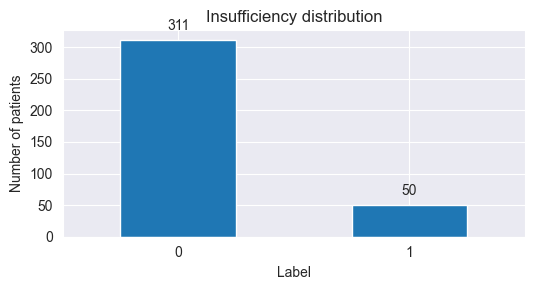

In [168]:
plot_bars(df, ['Label'], 'patients', 'Insufficiency distribution', 0)

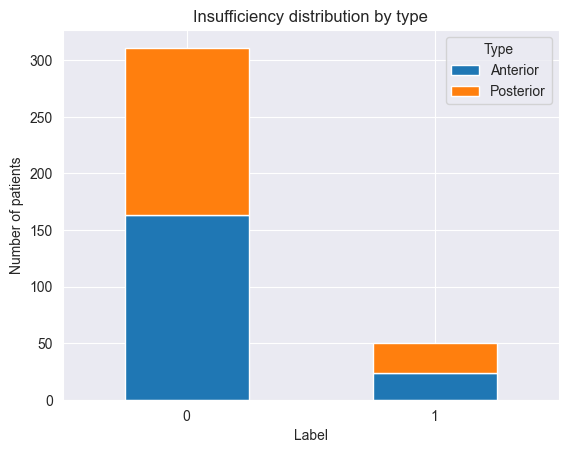

In [169]:
plot_gr_bars(df, ['Label', 'Type'], 'patients', 'Insufficiency distribution by type')

In [170]:
count = ((df['Type'] == 'Anterior') & (df['Label'] == 1)).sum()
print(f'Insufficiency Anterior {count}')
count = ((df['Type'] == 'Posterior') & (df['Label'] == 1)).sum()
print(f'Insufficiency Posterior {count}')

Insufficiency Anterior 24
Insufficiency Posterior 26


In [171]:
count = ((df['Type'] == 'Anterior') & (df['Label'] == 0)).sum()
print(f'Control Anterior {count}')
count = ((df['Type'] == 'Posterior') & (df['Label'] == 0)).sum()
print(f'Control Posterior {count}')

Control Anterior 163
Control Posterior 148


In [172]:
# Patients without origin to Other
df.loc[df['Origen étnico'].isnull(), 'Origen étnico'] = 'Otros'
df.loc[df['Origen étnico']=='otros', 'Origen étnico'] = 'Otros'

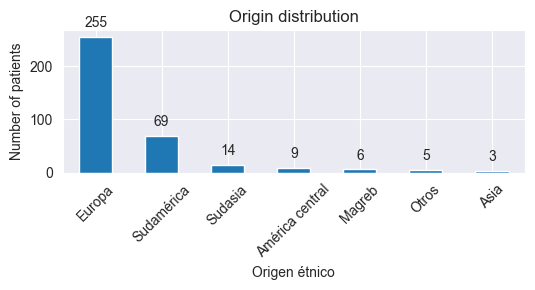

In [173]:
plot_bars(df, ['Origen étnico'], 'patients', 'Origin distribution', 45)

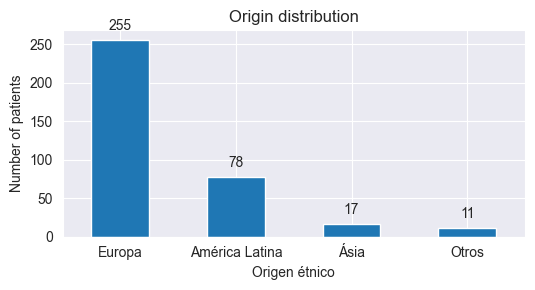

In [174]:
df.loc[(df['Origen étnico']=='América central') | (df['Origen étnico']=='Sudamérica'), 'Origen étnico'] = 'América Latina'
df.loc[(df['Origen étnico']=='Sudasia') | (df['Origen étnico']=='Asia'), 'Origen étnico'] = 'Ásia'
df.loc[(df['Origen étnico']=='Magreb') , 'Origen étnico'] = 'Otros'
plot_bars(df, ['Origen étnico'], 'patients', 'Origin distribution')

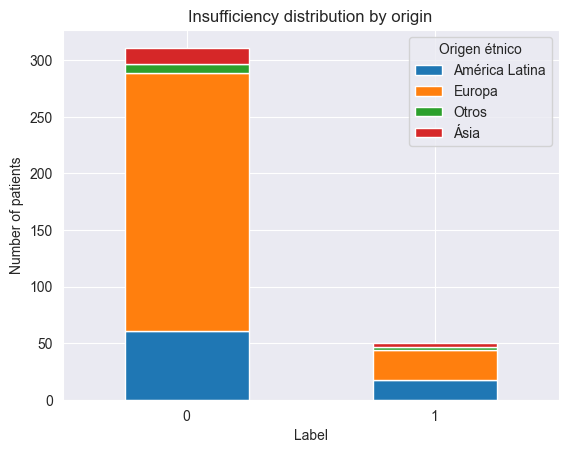

In [175]:
plot_gr_bars(df, ['Label', 'Origen étnico'],'patients', 'Insufficiency distribution by origin')

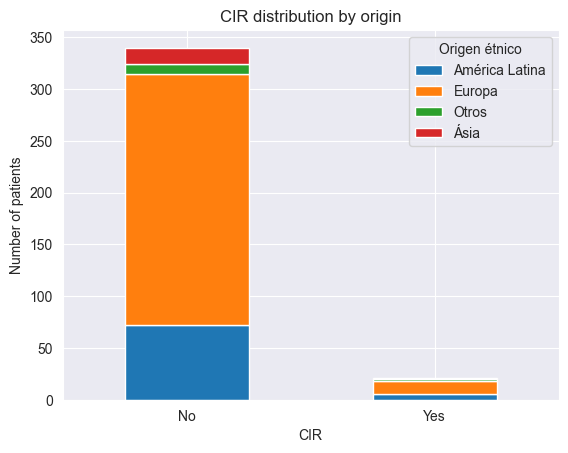

In [176]:
plot_gr_bars(df, ['CIR', 'Origen étnico'],'patients', 'CIR distribution by origin')

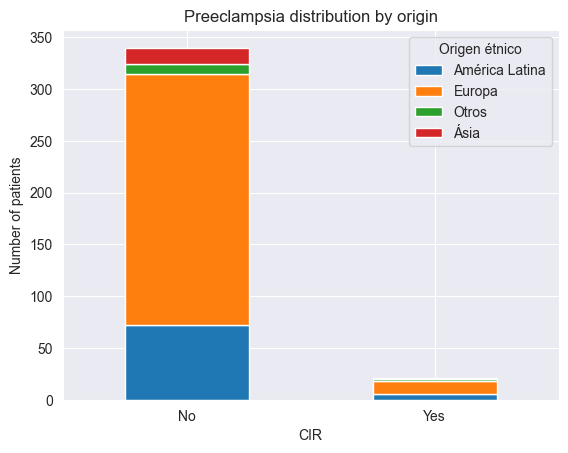

In [177]:
plot_gr_bars(df, ['CIR', 'Origen étnico'],'patients', 'Preeclampsia distribution by origin')

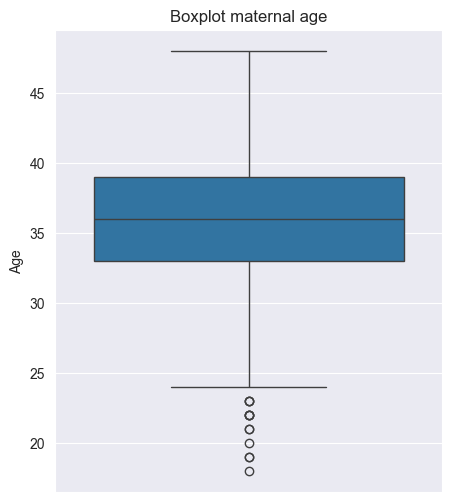

In [178]:
plt.figure(figsize=(5, 6))
sns.boxplot(data=df.drop(index=364), y='Edad materna')
plt.title('Boxplot maternal age')
plt.ylabel('Age')
plt.show()

In [179]:
# We save the unique record of the patients
record_ids = df['Record ID'].unique()

In [180]:
anterior_folders = [os.path.join(ANTERIOR_PATIENTS_PATH, carpeta) for carpeta in os.listdir(ANTERIOR_PATIENTS_PATH) if os.path.isdir(os.path.join(ANTERIOR_PATIENTS_PATH, carpeta))]
posterior_folders = [os.path.join(POSTERIOR_PATIENTS_PATH, carpeta) for carpeta in os.listdir(POSTERIOR_PATIENTS_PATH) if os.path.isdir(os.path.join(POSTERIOR_PATIENTS_PATH, carpeta))]
all_folders = [os.path.join(ALL_PATIENTS_PATH, carpeta) for carpeta in os.listdir(ALL_PATIENTS_PATH) if os.path.isdir(os.path.join(ALL_PATIENTS_PATH, carpeta))]

In [181]:
print('Anterior: {}'.format(len(anterior_folders)))
print('Posterior: {}'.format(len(posterior_folders))) 
print('All patients: {}'.format(len(all_folders))) 

Anterior: 187
Posterior: 173
All patients: 357


We repeat the process but creating the label having into account just FGR or just PE as label

In [182]:
fgr_1 = df[((df['CIR'] == 'Yes') | ((df['Fetal demise'] == 'Yes') & (df['Cause'] == 'RCIU')) |     
                              (df['BW percentile'] < 3 ))]

In [183]:
fgr_0 = df[df['Label']==0]

In [184]:
df_fgr = pd.concat([fgr_1, fgr_0], ignore_index=True)
df_fgr

,Record ID,Origen étnico,Edad materna,Nuliparidad,Fecha ecografía fetal,"Edad gestacional (setmanes,dies)",BW percentile,CIR,"Edad gestacional diagnóstico (semanas,dias)",Preeclampsia,"Edad gestacional diagnóstico (semanas,dias). Si postparto o intraparto, escribir 'postparto' o 'intraparto'",Tipo de PE,Muerte perinatal (hasta 28 días postparto),Fetal demise,Fetal demise due to insufficiency,Cause,Complete,Type,Label
0,17,Ásia,31,No,20/09/2022,"27,6",2.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Posterior,1
1,54,América Latina,41,Yes,13/10/2022,"27,6",6.0,Yes,38,No,NaN,NaN,No,No,No,NaN,Complete,Posterior,1
2,58,Europa,41,Yes,19/10/2022,"28,6",6.0,Yes,"34,5",No,NaN,NaN,No,No,No,NaN,Complete,Posterior,1
3,87,América Latina,29,Yes,08/11/2022,"27,3",1.0,Yes,"35,3",Yes,"35,3",PE tardía (>32sg),No,No,No,NaN,Complete,Anterior,1
4,91,Europa,40,Yes,09/11/2022,28,4.0,Yes,"31,2",Yes,"34,6",PE tardía (>32sg),No,No,No,NaN,Complete,Anterior,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,362,Otros,22,Yes,06/06/2023,27,71.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Posterior,0
338,363,Europa,26,Yes,06/06/2023,"27,3",99.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Posterior,0
339,364,Europa,41,No,06/06/2023,"27,3",68.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Anterior,0
340,365,Europa,0,Yes,08/06/2023,"27,3",78.0,No,NaN,No,NaN,NaN,No,No,No,NaN,Complete,Anterior,0


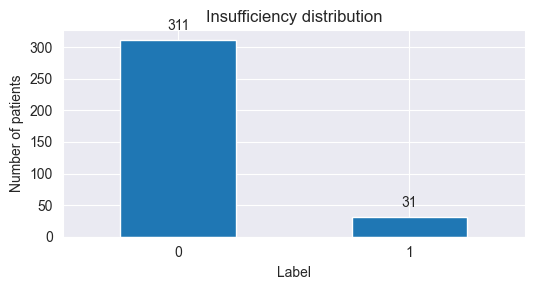

In [185]:
plot_bars(df_fgr, ['Label'], 'patients', 'Insufficiency distribution', 0)

In [186]:
pe_1 =  df[df['Preeclampsia'] == 'Yes']

In [187]:
df_pe = pd.concat([pe_1, fgr_0], ignore_index=True)

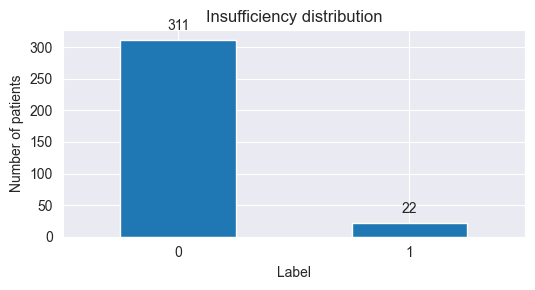

In [188]:
plot_bars(df_pe, ['Label'], 'patients', 'Insufficiency distribution', 0)

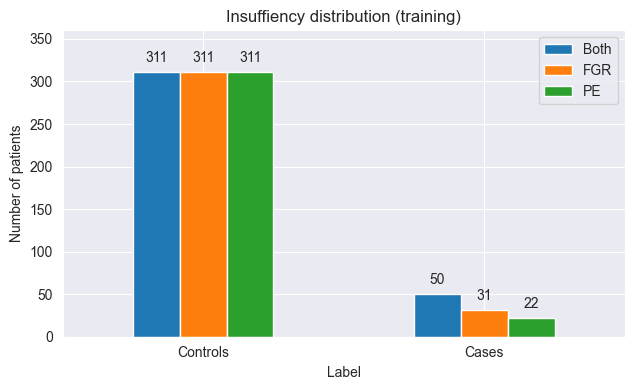

In [189]:
plot_combined_bars3(df, df_fgr, df_pe, ['Label'], 'patients', 'Insuffiency distribution (training)')

In [190]:
record_ids_fgr = df_fgr['Record ID'].unique()
record_ids_pe = df_pe['Record ID'].unique()

In [191]:
count = ((df_fgr['Type'] == 'Anterior') & (df_fgr['Label'] == 0)).sum()
print(f'Control Anterior {count}')
count = ((df_fgr['Type'] == 'Posterior') & (df_fgr['Label'] == 0)).sum()
print(f'Control Posterior {count}')

Control Anterior 163
Control Posterior 148


In [192]:
count = ((df_pe['Type'] == 'Anterior') & (df_pe['Label'] == 0)).sum()
print(f'Control Anterior {count}')
count = ((df_pe['Type'] == 'Posterior') & (df_pe['Label'] == 0)).sum()
print(f'Control Posterior {count}')

Control Anterior 163
Control Posterior 148


## Validation

In [221]:
VAL_DATA_PATH = config['VALIDATION']['db_path']
VAL_ANTERIOR_PATIENTS_PATH = config['VALIDATION']['ant_patients_path']
VAL_POSTERIOR_PATIENTS_PATH = config['VALIDATION']['pst_patients_path']
VAL_ANTERIOR_POSTERIOR_PATH = config['VALIDATION']['anterior_posterior_path']
VAL_ALL_PATIENTS_PATH = config['VALIDATION']['all_path']
df_val_all = pd.read_csv(VAL_DATA_PATH, sep=';')

# Only patients with completed study
df_val = df_val_all[df_val_all['Complete']=='Complete'].copy()
df_val_ant_post = pd.read_csv(VAL_ANTERIOR_POSTERIOR_PATH, sep=';')
for index, row in df_val_ant_post.iterrows():
    if row['ANTERIOR'].astype(int) in df_val['Record ID'].values:
        df_val.loc[df_val['Record ID'] == row['ANTERIOR'], 'Type'] = 'Anterior'
    if row['POSTERIOR'].astype(int) in df_val['Record ID'].values:
        df_val.loc[df_val['Record ID'] == row['POSTERIOR'], 'Type'] = 'Posterior'

In [198]:
print('Total number of rows: ', df_val_all.shape[0])
print('Patients with completed study: ', df_val.shape[0])

Total number of rows:  84
Patients with completed study:  83


In [226]:
# Output variable Insufficiency
df_val.loc[:, 'Label'] =  np.where(((df_val['CIR'] == 'Yes') |   
                              ((df_val['Fetal demise'] == 'Yes') & (df_val['Fetal demise due to insufficiency'] == 'Yes')) |
                              (df_val['BW percentile'] < 3 ) | 
                              (df_val['Preeclampsia'] == 'Yes')), 1, 0) 

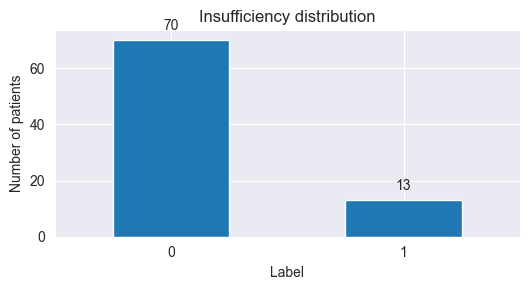

In [200]:
plot_bars(df_val, ['Label'], 'patients', 'Insufficiency distribution', 0)

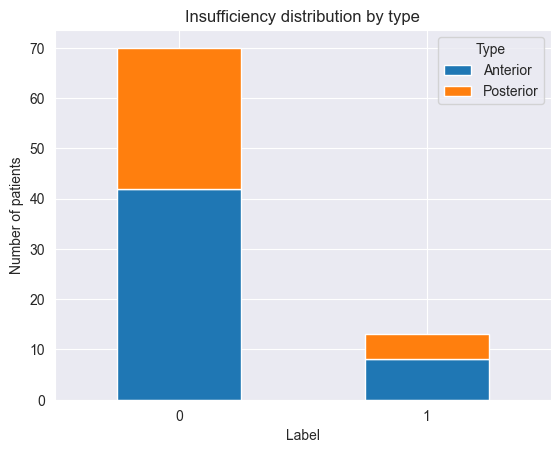

In [201]:
plot_gr_bars(df_val, ['Label', 'Type'], 'patients', 'Insufficiency distribution by type')

In [202]:
count = ((df_val['Type'] == 'Anterior') & (df_val['Label'] == 0)).sum()
print(f'Insufficiency Anterior {count}')
count = ((df_val['Type'] == 'Posterior') & (df_val['Label'] == 0)).sum()
print(f'Insufficiency Posterior {count}')

Insufficiency Anterior 42
Insufficiency Posterior 28


In [203]:
count = ((df_val['Type'] == 'Anterior') & (df_val['Label'] == 0)).sum()
print(f'Control Anterior {count}')
count = ((df_val['Type'] == 'Posterior') & (df_val['Label'] == 0)).sum()
print(f'Control Posterior {count}')

Control Anterior 42
Control Posterior 28


In [204]:
# Patients without origin to Other
df_val.loc[df_val['Origen étnico'].isnull(), 'Origen étnico'] = 'Otros'
df_val.loc[df_val['Origen étnico']=='otros', 'Origen étnico'] = 'Otros'

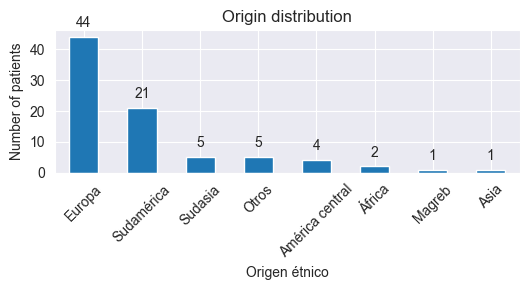

In [205]:
plot_bars(df_val, ['Origen étnico'], 'patients', 'Origin distribution', 45)

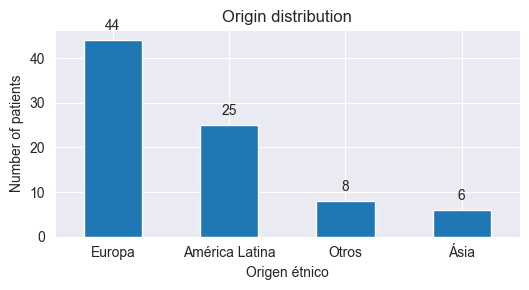

In [206]:
df_val.loc[(df_val['Origen étnico']=='América central') | (df_val['Origen étnico']=='Sudamérica'), 'Origen étnico'] = 'América Latina'
df_val.loc[(df_val['Origen étnico']=='Sudasia') | (df_val['Origen étnico']=='Asia'), 'Origen étnico'] = 'Ásia'
df_val.loc[(df_val['Origen étnico']=='Magreb') |  (df_val['Origen étnico']=='África'), 'Origen étnico'] = 'Otros'
plot_bars(df_val, ['Origen étnico'], 'patients', 'Origin distribution')

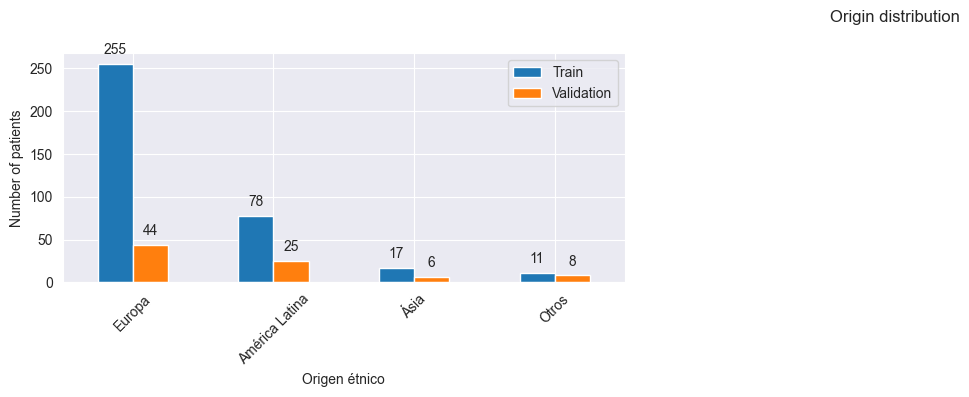

In [207]:
plot_combined_bars(df, df_val, ['Origen étnico'], 'patients', 'Origin distribution', 45)

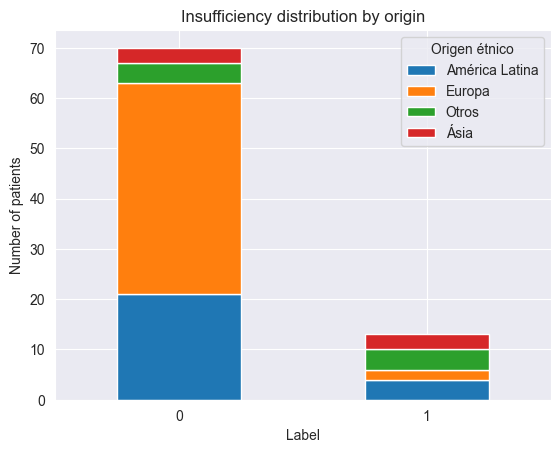

In [208]:
plot_gr_bars(df_val, ['Label', 'Origen étnico'],'patients', 'Insufficiency distribution by origin')

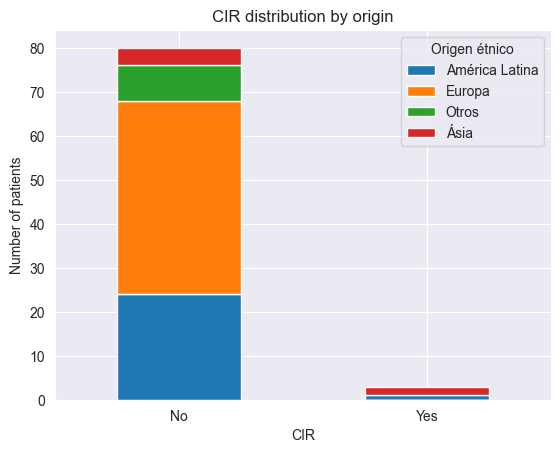

In [209]:
plot_gr_bars(df_val, ['CIR', 'Origen étnico'],'patients', 'CIR distribution by origin')

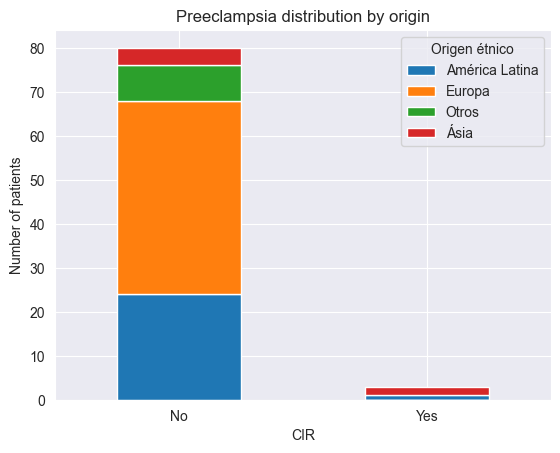

In [210]:
plot_gr_bars(df_val, ['CIR', 'Origen étnico'],'patients', 'Preeclampsia distribution by origin')

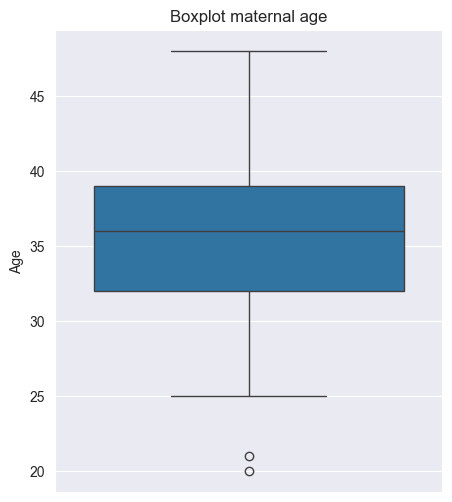

In [211]:
plt.figure(figsize=(5, 6))
sns.boxplot(data=df_val, y='Edad materna')
plt.title('Boxplot maternal age')
plt.ylabel('Age')
plt.show()

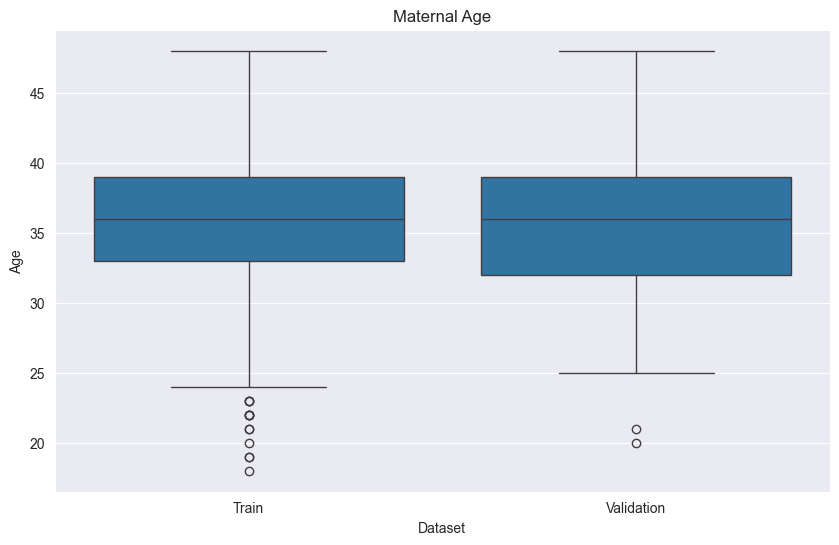

In [212]:
df['Dataset'] = 'Train'
df_val['Dataset'] = 'Validation'

combined_df = pd.concat([df.drop(index=364), df_val])
palette_colors = {'Train': 'blue', 'Validation': 'orange'}
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dataset', y='Edad materna', data=combined_df)

plt.title('Maternal Age')
plt.ylabel('Age')
plt.show()

In [213]:
p_value = levene(df["Edad materna"], df_val["Edad materna"])
p_value #>0.05: homocedasticity

LeveneResult(statistic=0.19870549644875368, pvalue=0.655986030836936)

In [214]:
stats.shapiro(df["Edad materna"])#>0.05: normality

ShapiroResult(statistic=0.9276878237724304, pvalue=3.3008422384295244e-12)

In [215]:
stats.shapiro(df_val["Edad materna"])

ShapiroResult(statistic=0.9681079983711243, pvalue=0.03699806332588196)

In [216]:
from scipy.stats import mannwhitneyu

u_statistic, p_value = mannwhitneyu(df["Edad materna"], df_val["Edad materna"])
print("U-statistic:", u_statistic)
print("P-value:", p_value)

U-statistic: 15446.5
P-value: 0.6587358435884758


There are not significant differences between the distribution of the two groups (train and validation)

In [217]:
# We save the unique record of the patients
record_ids_val = df_val['Record ID'].unique()

In [218]:
len(record_ids_val)

83

In [222]:
val_anterior_folders = [os.path.join(VAL_ANTERIOR_PATIENTS_PATH, carpeta) for carpeta in os.listdir(VAL_ANTERIOR_PATIENTS_PATH) if os.path.isdir(os.path.join(VAL_ANTERIOR_PATIENTS_PATH, carpeta))]
val_posterior_folders = [os.path.join(VAL_POSTERIOR_PATIENTS_PATH, carpeta) for carpeta in os.listdir(VAL_POSTERIOR_PATIENTS_PATH) if os.path.isdir(os.path.join(VAL_POSTERIOR_PATIENTS_PATH, carpeta))]
val_all_folders = [os.path.join(VAL_ALL_PATIENTS_PATH, carpeta) for carpeta in os.listdir(VAL_ALL_PATIENTS_PATH) if os.path.isdir(os.path.join(VAL_ALL_PATIENTS_PATH, carpeta))]

In [223]:
print('Anterior: {}'.format(len(val_anterior_folders)))
print('Posterior: {}'.format(len(val_posterior_folders)))
print('All: {}'.format(len(val_all_folders)))

Anterior: 51
Posterior: 33
All: 357


In [ ]:
df_val_fgr = df_val.copy()
# Output variable Insufficiency
df_val_fgr.loc[:, 'Label'] =  np.where(((df_val_fgr['CIR'] == 'Yes') |   
                              ((df_val_fgr['Fetal demise'] == 'Yes') & (df_val_fgr['Cause'] == 'RCIU')) |     
                              (df_val_fgr['BW percentile'] < 3 )), 1, 0) 
                              #(df['Preeclampsia'] == 'Yes')), 1, 0) 

In [227]:
df_val_fgr_1 = df_val[((df_val['CIR'] == 'Yes') | ((df_val['Fetal demise'] == 'Yes') & (df_val ['Cause'] == 'RCIU')) |     
                              (df_val['BW percentile'] < 3 ))]

In [228]:
df_val_fgr_0 = df_val[df_val['Label']==0]

In [ ]:
df_val_fgr = pd.concat([df_val_fgr_1, df_val_fgr_0], ignore_index=True)

In [230]:
record_ids_val_fgr =  df_val_fgr['Record ID'].unique()

In [231]:
df_val_pe_1 = df_val[df_val['Preeclampsia'] == 'Yes']

In [232]:
df_val_pe = pd.concat([df_val_pe_1, df_val_fgr_0], ignore_index=True)

In [233]:
count = ((df_val_fgr['Type'] == 'Anterior') & (df_val_fgr['Label'] == 0)).sum()
print(f'Insufficiency Anterior {count}')
count = ((df_val_fgr['Type'] == 'Posterior') & (df_val_fgr['Label'] == 0)).sum()
print(f'Insufficiency Posterior {count}')

Insufficiency Anterior 42
Insufficiency Posterior 28


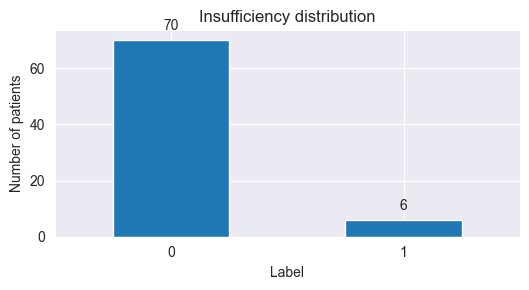

In [234]:
plot_bars(df_val_fgr, ['Label'], 'patients', 'Insufficiency distribution', 0)

In [235]:
count = ((df_val_pe['Type'] == 'Anterior') & (df_val_pe['Label'] == 0)).sum()
print(f'Insufficiency Anterior {count}')
count = ((df_val_pe['Type'] == 'Posterior') & (df_val_pe['Label'] == 0)).sum()
print(f'Insufficiency Posterior {count}')

Insufficiency Anterior 42
Insufficiency Posterior 28


In [ ]:
record_ids_val_pe =  df_val_pe['Record ID'].unique()

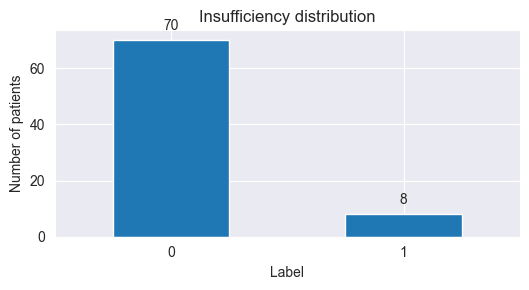

In [236]:
plot_bars(df_val_pe, ['Label'], 'patients', 'Insufficiency distribution', 0)

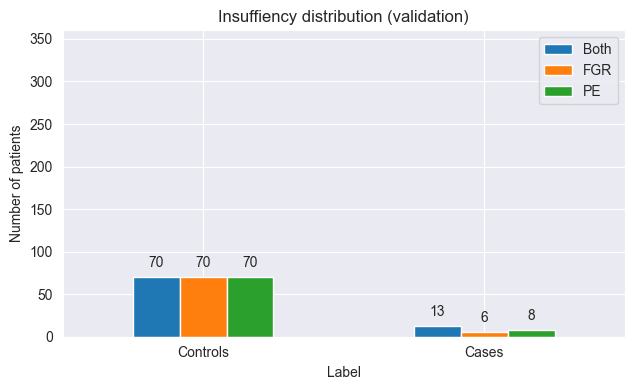

In [237]:
plot_combined_bars3(df_val, df_val_fgr, df_val_pe, ['Label'], 'patients', 'Insuffiency distribution (validation)')

# Pixel spacing study
To detect the samples that show outliers in the pixel spacing we need to add the information to the dataset

In [88]:
def create_df(ids, original_dataframe, parent_path):
    """
    Merge the original dataframe with the x,y pixel space of every DICOM file in the patients folders
    :param ids: needed to find the patient ID folder
    :param original_dataframe: dataframe to merge
    :param parent_path: parent folder
    :return: dataframe with Record ID, file name, pixel spacing x, pixel spacing y, number of bits of the image
    """
    df_ps = pd.DataFrame(columns=["Record ID", "Image", "Pixel spacing x", "Pixel spacing y", "Bits"])
    for record_id in ids:
        patient_folder = os.path.join(parent_path, str(record_id))
        if os.path.exists(patient_folder):
            for file in os.listdir(patient_folder):
                if file.endswith(".dcm"):
                    ds = pydicom.dcmread(os.path.join(patient_folder, file))
                    # Element: Pixel Spacing
                    element = ds[0x00280030]
                    p_space_x = element.value[0]
                    p_space_y = element.value[1]
                    element2 = ds[0x00280100]
                    data = {
                        "Record ID": os.path.basename(patient_folder),
                        "Image": file,
                        "Pixel spacing x": p_space_x,
                        "Pixel spacing y": p_space_y,
                        "Bits": element2.value
                    }
                    df_ps.loc[len(df_ps)] = data
                    
    df_ps['Record ID'] = df_ps['Record ID'].astype('int64')
    
    return df_ps.merge(original_dataframe, on='Record ID', how='left')

## Anterior images (train)

In [ ]:
df_anterior = create_df(record_ids, df, ANTERIOR_PATIENTS_PATH)
print('Num. images {}'.format(df_anterior.shape[0]))

In [ ]:
print('Num. bits {}'.format(df_anterior["Bits"].unique()))

In [ ]:
plot_bars(df_anterior,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
boxplot_pixel_spacing(df_anterior)

In [86]:
def remove_outliers_pixel_spacing_x(df):
    """
    Removes the pixel spacing outliers of the dataframe using IQR
    :param df: dataframe
    :return: dataframe filtered 
    """
    Q1_x = df['Pixel spacing x'].quantile(0.25)
    Q3_x = df['Pixel spacing x'].quantile(0.75)
    IQR_x = Q3_x - Q1_x
    
    
    return df[(df['Pixel spacing x'] > (Q1_x - 1.5 * IQR_x)) & (df['Pixel spacing x'] < (Q3_x + 1.5 * IQR_x))]

In [ ]:
df_anterior_filtered = remove_outliers_pixel_spacing_x(df_anterior)
df_anterior_filtered

In [ ]:
df_anterior_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_filtered.csv', index=False)

In [ ]:
plot_bars(df_anterior_filtered,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_fgr_anterior = create_df(record_ids_fgr, df_fgr, ANTERIOR_PATIENTS_PATH)

In [ ]:
df_pe_anterior = create_df(record_ids_pe, df_pe, ANTERIOR_PATIENTS_PATH)

In [ ]:
df_fgr_anterior_filtered = remove_outliers_pixel_spacing_x(df_fgr_anterior)

In [ ]:
df_fgr_anterior_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_fgr_filtered.csv', index=False)

In [ ]:
df_pe_anterior_filtered = remove_outliers_pixel_spacing_x(df_pe_anterior)
df_pe_anterior

In [ ]:
df_pe_anterior_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_pe_filtered.csv', index=False)

## Anterior images (validation)

In [ ]:
df_val_anterior = create_df(record_ids_val, df_val, VAL_ANTERIOR_PATIENTS_PATH)
df_val_fgr_anterior = create_df(record_ids_val, df_val_fgr, VAL_ANTERIOR_PATIENTS_PATH)
df_val_pe_anterior = create_df(record_ids_val, df_val_pe, VAL_ANTERIOR_PATIENTS_PATH)

In [ ]:
plot_bars(df_val_anterior,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_anterior_filtered = remove_outliers_pixel_spacing_x(df_val_anterior)
plot_bars(df_val_anterior_filtered,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_anterior_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_val_filtered.csv', index=False)

In [ ]:
plot_bars(df_val_fgr_anterior,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_fgr_anterior_filtered = remove_outliers_pixel_spacing_x(df_val_fgr_anterior)
plot_bars(df_val_fgr_anterior_filtered,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_fgr_anterior_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_val_fgr_filtered.csv', index=False)

In [ ]:
plot_bars(df_val_pe_anterior,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_pe_anterior_filtered = remove_outliers_pixel_spacing_x(df_val_pe_anterior)
plot_bars(df_val_pe_anterior_filtered,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_pe_anterior_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_val_pe_filtered.csv', index=False)

## Posterior images (train)

In [ ]:
df_posterior = create_df(record_ids, df, POSTERIOR_PATIENTS_PATH)
print('Num. images {}'.format(df_posterior.shape[0]))

In [ ]:
print('Num. bits {}'.format(df_posterior["Bits"].unique()))

In [ ]:
plot_bars(df_posterior,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
boxplot_pixel_spacing(df_posterior)

In [ ]:
df_posterior_filtered = remove_outliers_pixel_spacing_x(df_posterior)
df_posterior_filtered

In [ ]:
plot_bars(df_posterior_filtered,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_posterior_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_posterior_filtered.csv', index=False)

## All images (train)

In [ ]:
df_all = create_df(record_ids, df, ALL_PATIENTS_PATH)

In [ ]:
plot_bars(df_all,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_all_filtered = remove_outliers_pixel_spacing_x(df_all)

In [ ]:
df_all_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_all_filtered.csv', index=False)

In [ ]:
plot_bars(df_all_filtered,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_fgr_all = create_df(record_ids, df_fgr, ALL_PATIENTS_PATH)

In [ ]:
df_pe_all = create_df(record_ids, df_pe, ALL_PATIENTS_PATH)

In [ ]:
plot_bars(df_fgr_all,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_fgr_all_filtered = remove_outliers_pixel_spacing_x(df_fgr_all)

In [ ]:
plot_bars(df_fgr_all_filtered,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_fgr_all_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_fgr_all_filtered.csv', index=False)

In [ ]:
df_pe_all_filtered = remove_outliers_pixel_spacing_x(df_pe_all)

In [ ]:
df_pe_all_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_pe_all_filtered.csv', index=False)

## All images (validation)

In [ ]:
df_val_fgr_all = create_df(record_ids_val, df_val_fgr, VAL_ALL_PATIENTS_PATH)

In [ ]:
plot_bars(df_val_fgr_all,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_fgr_all_filtered = remove_outliers_pixel_spacing_x(df_val_fgr_all)
df_val_fgr_all_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_val_fgr_all_filtered.csv', index=False)

In [ ]:
df_val_pe_all = create_df(record_ids_val, df_val_pe, VAL_ALL_PATIENTS_PATH)

In [ ]:
plot_bars(df_val_pe_all,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_pe_all_filtered = remove_outliers_pixel_spacing_x(df_val_pe_all)
df_val_pe_all_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_val_pe_all_filtered.csv', index=False)

In [ ]:
df_val_all = create_df(record_ids_val, df_val, VAL_ALL_PATIENTS_PATH)

In [ ]:
plot_bars(df_val_all,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
df_val_all_filtered = remove_outliers_pixel_spacing_x(df_val_all)
df_val_all_filtered[['Record ID','Image','Pixel spacing x', 'Label']].to_csv('../data/samples_val_all_filtered.csv', index=False)

# Image preprocessing
## Mask erosion
To avoid possible errors of the doctor when delination of the ROI we erode the masks for 5 pixels.

In [84]:
def erode_mask(_image, pixels=5):
    """
    Erode image
    :param _image: 2D image to erode
    :param pixels: number of pixels. Deefault 5
    :return: 2D eroded image
    """

    erosion_footprint = ndi.generate_binary_structure(_image.ndim, _image.ndim)
    eroded_image = _image.copy()
    eroded_image = binary_erosion(eroded_image, erosion_footprint, iterations=pixels)

    return eroded_image * 1

In [ ]:
# Example 
examples = df_anterior[(df_anterior['Record ID']==103)]
for _, row in examples.iterrows():  
    path = ANTERIOR_PATIENTS_PATH+'\\'+str(row['Record ID'])+'\\'+row['Image']
    mask = get_mask_example(ANTERIOR_PATIENTS_PATH+'\\'+str(row['Record ID'])+'\\'+os.path.splitext(os.path.basename(row['Image']))[0] + '_mask.png')
    mask_eroded = erode_mask(mask)
    dicom_image =  pydicom.dcmread(path).pixel_array
    image = cv2.cvtColor(dicom_image, cv2.COLOR_RGB2GRAY)
    masked_image = image * mask
    masked_image_eroded = image * mask_eroded
    
    plt.figure(figsize=(10, 6), dpi=100)
    plt.subplot(1, 2, 1)
    plt.imshow(masked_image, cmap='gray') 
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(masked_image_eroded, cmap='gray') 
    plt.title('Eroded Image'), plt.xticks([]), plt.yticks([])
   
    plt.show()

In [85]:
def validate_image_and_mask(image, mask):
    if image.shape[0:2] != mask.shape[0:2]:
        raise ValueError("Shape of DICOM image and mask aren't the same")
    non_zero_pixels = np.count_nonzero(mask)
    if non_zero_pixels < 400:
       raise ValueError("The mask has less than 400 pixels.")
    
    return non_zero_pixels


def crop_image(image, mask):
    """
    Crop the image obtaining a ROI in 2D and 1D array.
    :param image: uint8 image with dimensions NxM to crop
    :param mask: uint8 mask image with dimensions NxM with grey level value 1 in the ROI pixels and 0 in non-ROI pixels.
    :return: 1D array masked image, 2D array masked image with 0 in non-ROI pixels, 2D array masked image with 0 in non-ROI pixels
    """
    roi_1d = image[mask == np.max(mask)]   
    roi_2d = image * mask
    
    return roi_1d, roi_2d

def get_roi(dicom_path, mask_path, normalize_image=False, resegment=False, erode=True, k=6):
    """
    Converts image and mask to grey scale, validates shapes and minimum of ROI of 400 pixels
    :param dicom_path: path to the dicom file 
    :param mask_path: path to the mask file
    :param normalize_image: if normalize with 3sigma normalization
    :param erode: if True erode mask
    :param k: k bits for quantification
    :return:  1D array masked image, 2D array masked image with 0 grey level value in non-ROI pixels
    """
    # Image (RGB image)
    image = pydicom.dcmread(dicom_path).pixel_array
    # Mask (RGB image with transparency)
    mask = plt.imread(mask_path).astype(np.uint8)
    image = image.astype(np.uint8)

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    if erode:
        mask = erode_mask(mask)
        
    roi_size = validate_image_and_mask(image,mask)
   
    if normalize_image:
        return normalize_image_intensity(image, mask, resegment, k), mask, roi_size
    else:
        return crop_image(image, mask), mask, roi_size
    
def get_roi_sizes(input_csv, image_path):
    """
    Add roi sizes to input_csv
    """ 
    try:
        with open(input_csv, 'r') as inFile:
          cr = csv.DictReader(inFile, lineterminator='\n')
          cases = []
          for row_idx, row in enumerate(cr, start=1):
            cases.append(row)
    except Exception:
        logger.error('CSV READ FAILED', exc_info=True)
        
       
    for case in cases:
         
         patient_folder = os.path.join(image_path, str(case['Record ID']))
         dicom_path = os.path.join(patient_folder, case['Image'])
         mask_path = os.path.join(patient_folder, os.path.splitext(os.path.basename(dicom_path))[0] + '_mask.png')

         (_, _), _, size = get_roi(dicom_path, mask_path)
         
         case['ROI pixels'] = size
 
    return pd.DataFrame(cases)

We save the files of samples without outliers updating the roi sizes (calculated without interpolation).

In [ ]:
new_df_anterior_filtered = get_roi_sizes('../data/samples_filtered.csv', ANTERIOR_PATIENTS_PATH)

In [ ]:
new_df_anterior_filtered.to_csv('../data/samples_filtered.csv', index=False)

In [ ]:
new_df_anterior_fgr_filtered = get_roi_sizes('../data/samples_fgr_filtered.csv', ANTERIOR_PATIENTS_PATH)
new_df_anterior_fgr_filtered.to_csv('../data/samples_fgr_filtered.csv', index=False)

In [ ]:
new_df_anterior_pe_filtered = get_roi_sizes('../data/samples_pe_filtered.csv', ANTERIOR_PATIENTS_PATH)
new_df_anterior_pe_filtered.to_csv('../data/samples_pe_filtered.csv', index=False)

In [ ]:
new_df_posterior_filtered = get_roi_sizes('../data/samples_posterior_filtered.csv', POSTERIOR_PATIENTS_PATH)
new_df_posterior_filtered.to_csv('../data/samples_posterior_filtered.csv', index=False)

In [ ]:
new_df_all_filtered = get_roi_sizes('../data/samples_all_filtered.csv', ALL_PATIENTS_PATH)
new_df_all_filtered.to_csv('../data/samples_all_filtered.csv', index=False)

In [ ]:
new_df_fgr_all_filtered = get_roi_sizes('../data/samples_fgr_all_filtered.csv', ALL_PATIENTS_PATH)
new_df_fgr_all_filtered.to_csv('../data/samples_fgr_all_filtered.csv', index=False)

In [ ]:
new_df_pe_all_filtered = get_roi_sizes('../data/samples_pe_all_filtered.csv', ALL_PATIENTS_PATH)
new_df_pe_all_filtered.to_csv('../data/samples_pe_all_filtered.csv', index=False)

In [ ]:
new_df_val_filtered = get_roi_sizes('../data/samples_val_filtered.csv', VAL_ANTERIOR_PATIENTS_PATH)
new_df_val_filtered.to_csv('../data/samples_val_filtered.csv', index=False)

In [ ]:
new_df_val_all_filtered = get_roi_sizes('../data/samples_val_all_filtered.csv', VAL_ALL_PATIENTS_PATH)
new_df_val_all_filtered.to_csv('../data/samples_val_all_filtered.csv', index=False)

In [ ]:
new_df_fgr_filtered = get_roi_sizes('../data/samples_val_fgr_filtered.csv', VAL_ANTERIOR_PATIENTS_PATH)
new_df_fgr_filtered.to_csv('../data/samples_val_fgr_filtered.csv', index=False)

In [ ]:
new_df_fgr_all_filtered = get_roi_sizes('../data/samples_val_fgr_all_filtered.csv', VAL_ALL_PATIENTS_PATH)
new_df_fgr_all_filtered.to_csv('../data/samples_val_fgr_all_filtered.csv', index=False)

In [ ]:
new_df_pe_filtered = get_roi_sizes('../data/samples_val_pe_filtered.csv', VAL_ANTERIOR_PATIENTS_PATH)
new_df_pe_filtered.to_csv('../data/samples_val_pe_filtered.csv', index=False)

In [ ]:
new_df_pe_all_filtered = get_roi_sizes('../data/samples_val_pe_all_filtered.csv', VAL_ALL_PATIENTS_PATH)
new_df_pe_all_filtered.to_csv('../data/samples_val_pe_all_filtered.csv', index=False)

## Resampling
The pixel spatial resolution is one of the most influential factors in texture analysis because it determines the physical area represented by each pixel, influencing the spatial relationship between pixels. Instead of ignoring the images which present outliers in the pixel space we will use resampling with linear interpolation using library pyradiomics to 0.1mm x 0.1mm (the mean of the pixel spacing).

In [ ]:
print(df_anterior['Pixel spacing x'].describe())

In [ ]:
print(df_posterior['Pixel spacing x'].describe())

In [134]:
def preprocess(image, mask, normalize = False, size=0.1, plot = False):
    """
    Interpolate image and mask 
    :param normalize: normalize all image with z-score normalization with removing outliers
    :param image: SimpleITK image 
    :param mask: SimpleITK image mask
    :param size: pixel space size in mm
    :param plot: plot interpolation result
    :return: roi interpolated, image interpolated, mask interpolated
    """
    
    if normalize:
      image = imageoperations.normalizeImage(image, **{'normalizeScale':50})
        
    (ii, im) = imageoperations.resampleImage(image, mask, **{"resampledPixelSpacing":[size, size, size], "label":1,
                                                                   'interpolator': sitk.sitkLinear})
    array_ii = sitk.GetArrayFromImage(ii[:,:,0])
    array_im = sitk.GetArrayFromImage(im[:,:,0])
   
    masked_image = array_ii * array_im
    
    if plot:
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(array_ii, cmap='gray')
        plt.title('Bounding box '+str(masked_image.shape))
        plt.axis('off')
    
        plt.subplot(1, 2, 2)
        plt.imshow(masked_image, cmap='gray')
        plt.title('ROI')
        plt.axis('off')
        
        plt.show()
        
    return masked_image, array_ii, array_im

In [243]:
patient = 12
dicom_path = ANTERIOR_PATIENTS_PATH+'\\'+str(patient)+'\\IMG_20220913_1_1.dcm'
mask_path =  ANTERIOR_PATIENTS_PATH+'\\'+str(patient)+'\\IMG_20220913_1_1_mask.png'
image_3d = sitk.ReadImage(dicom_path, sitk.sitkUInt8)
mask = plt.imread(mask_path).astype(np.uint8)
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask_eroded = erode_mask(mask)
mask_2d = sitk.GetImageFromArray(mask_eroded) 
mask_3d = sitk.JoinSeries(mask_2d)
mask_3d.SetSpacing(image_3d.GetSpacing())


INFO:radiomics.imageoperations:Applying resampling from spacing [0.138425 0.138425 1.      ] and size [1136  852    1] to spacing [0.1 0.1 1. ] and size [650, 142, 1]


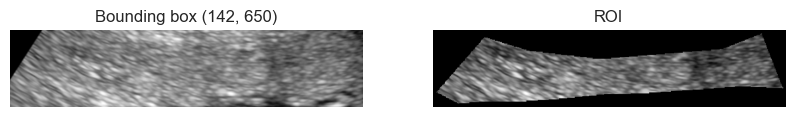

In [239]:
roi2d, image , mask = preprocess(image_3d, mask_3d,normalize=True,plot=True)

INFO:radiomics.imageoperations:Applying resampling from spacing [0.188166 0.188166 1.      ] and size [1136  852    1] to spacing [0.1 0.1 1. ] and size [921, 469, 1]


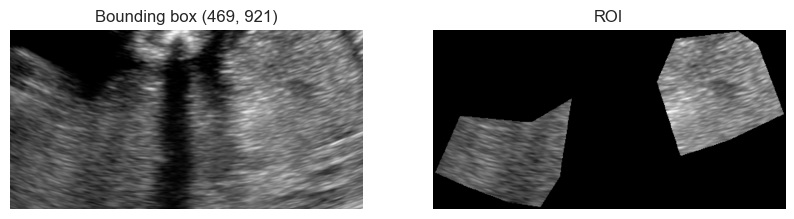

In [240]:
patient = 17
dicom_path = POSTERIOR_PATIENTS_PATH+'\\'+str(patient)+'\\IMG_20220920_1_1.dcm'
mask_path =  POSTERIOR_PATIENTS_PATH+'\\'+str(patient)+'\\IMG_20220920_1_1_mask.png'
image_3d = sitk.ReadImage(dicom_path, sitk.sitkUInt8)
mask = plt.imread(mask_path).astype(np.uint8)
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask_eroded = erode_mask(mask)
mask_2d = sitk.GetImageFromArray(mask_eroded) 
mask_3d = sitk.JoinSeries(mask_2d)
mask_3d.SetSpacing(image_3d.GetSpacing())
roi2d, img , mask = preprocess(image_3d, mask_3d, plot=True)

## Intensity standardization and intensity level reduction (quantization) for texture analysis 
Normalization is applied to reduce systemic differences between different sensors, to increase the repeatability of features and make them more robust against variations due to image acquisition. As we are using the same scanner for all the samples we don't do it. The intensity level of the image are typically resampled into a reduced number of discrete bins. Discretisation facilitates the calculation of texture features. This discretization can be done fixing the number of bins or a fixed bin width. There is a discussion in literature about what is the best option and pyradiomics recommends the second one. Duron et al. that studied the feature repeatability in ultrasound imaging. They did Z-score intensity standardization and outliers removal in all image (recommended by pyradiomics) and also based on the ROI. In the first case a good  number of repeatable features (ICC ≥ 0.7) was obtained with a fixed bin number and in the second with a fixed width. With no standarization the best was the fixed width.

In [132]:
def get_cropped_images(ids, dataframe, path):
    """
    Calculates number of ROI pixels
    :return: list of images ROI with interpolation
    """
    dataframe['ROI pixels'] = None 
  
    cropped_images = []
    
    for record_id in ids:
        patient_folder = os.path.join(path, str(record_id))
        
        if os.path.exists(patient_folder):
            dcms_of_interest_file = dataframe[dataframe['Record ID'] == record_id]['Image'].tolist()
                 
            for dicom_file in os.listdir(patient_folder):
                if dicom_file in dcms_of_interest_file:
                    dicom_path = os.path.join(patient_folder, dicom_file)
                    mask_path = os.path.join(patient_folder, os.path.splitext(os.path.basename(dicom_path))[0] + '_mask.png')

                    image_3d = sitk.ReadImage(dicom_path, sitk.sitkUInt8)
                    mask = plt.imread(mask_path).astype(np.uint8)
                    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
                    mask_eroded = erode_mask(mask)
                    mask_2d = sitk.GetImageFromArray(mask_eroded) 
                    mask_3d = sitk.JoinSeries(mask_2d)
                    mask_3d.SetSpacing(image_3d.GetSpacing())
                   
                    _, im , mask = preprocess(image_3d, mask_3d, size=0.1)
                    cropped_images.append(im[mask==np.max(mask)])
                    num_p = np.sum(mask == np.max(mask))
                   
                    df_index = dataframe[(dataframe['Record ID'] == record_id) & (dataframe['Image'] == dicom_file)].index
                    dataframe.at[df_index[0], 'ROI pixels'] = num_p
                   
    return cropped_images

In [ ]:
roi1ds = get_cropped_images(record_ids, df_anterior, ANTERIOR_PATIENTS_PATH)

In [ ]:
# We save the samples file with the number of ROI pixels per sample
df_anterior[['Record ID','Image','Pixel spacing x', 'ROI pixels', 'Label']].to_csv('../data/samples.csv', index=False)

In [ ]:
roi1ds_pos = get_cropped_images(record_ids, df_posterior, POSTERIOR_PATIENTS_PATH)

In [ ]:
# Statistics after preprocessing 
show_image_stadistics(roi1ds, True)

In [ ]:
df_posterior[['Record ID','Image','Pixel spacing x', 'ROI pixels', 'Label']].to_csv('../data/samples_post.csv', index=False)

In [ ]:
# Statistics after preprocessing
show_image_stadistics(roi1ds_pos, True)

In [ ]:
#We do the same when separate the label for FGR and PE
roi1ds_fgr = get_cropped_images(record_ids, df_fgr_anterior, ANTERIOR_PATIENTS_PATH)

In [ ]:
df_fgr_anterior[['Record ID','Image','Pixel spacing x', 'ROI pixels', 'Label']].to_csv('../data/samples_fgr.csv', index=False)

In [ ]:
roi1ds_pe = get_cropped_images(record_ids, df_pe_anterior, ANTERIOR_PATIENTS_PATH)

In [ ]:
df_pe_anterior[['Record ID','Image','Pixel spacing x', 'ROI pixels', 'Label']].to_csv('../data/samples_pe.csv', index=False)

# Features
## LBP features
Pyradiomics allows to filter the image with LBP before extract the features but don't return the histograms. As we want to add this information too we make our LBP feature extractor.

In [244]:
_, image, mask = preprocess(image_3d, mask_3d, normalize=False)

INFO:radiomics.imageoperations:Applying resampling from spacing [0.138425 0.138425 1.      ] and size [1136  852    1] to spacing [0.1 0.1 1. ] and size [650, 142, 1]


In [124]:
# https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

def lbp_features_extractor(image, mask, plot=False):
    """
    Compute the uniform LBP histogram features (R=1, P=8). The mask is eroded to avoid the border effect.
    :param image: 2D array image
    :param mask: 2D array image with 1 in ROI pixels and 0 in non-ROI pixels
    :return: features dictionary (Energy,Entropy and LBP normalized histogram)
    """

    features = {}
    R = [1,2,3]
    P = [8,16,24] 

    for k in range(3):
        erosion_footprint = ndi.generate_binary_structure(mask.ndim, mask.ndim)
        eroded_mask = mask.copy()
        img =  image.copy()
        
        eroded_mask = binary_erosion(eroded_mask, erosion_footprint, border_value=0)
    
        lbp = feature.local_binary_pattern(img, P[k], R[k], 'uniform')
        lbp_masked = lbp * eroded_mask
        if plot:
             #    plt.imshow(lbp_masked, cmap="gray")
            
            plt.figure(figsize=(10, 4))
        
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Interpolated image (mask bounding box)')
            plt.axis('off')
        
            plt.subplot(1, 2, 2)
            plt.imshow(lbp_masked, cmap='gray')
            plt.title(f'LBP uniform R={R[k]} P={P[k]} (ROI)')
            plt.axis('off')
            
            plt.show()
        
        lbp_roi1d = lbp_masked[eroded_mask == np.max(eroded_mask)]
    
        # Values in LBP images ranges from [0, numPoints + 2], a value for each of the possible numPoints + 1
        # (possible rotation invariant prototypes along with an extra dimension for all patterns that are not uniform)
        hist, _ = np.histogram(lbp_roi1d, bins=range(0, P[k] + 3), range=(0, P[k] + 2))
        eps = 1e-7
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
    
        energy_label = f'LBP_R_{R[k]}_P_{P[k]}_Energy'
        entropy_label = f'LBP_R_{R[k]}_P_{P[k]}_Entropy'
        hist_label = f'LBP_R_{R[k]}_P_{P[k]}_Hist'
        features[energy_label] = np.sum(hist ** 2)
        features[entropy_label] = -np.sum(hist * np.log2(hist + 1e-9))
    
        for i, v in enumerate(hist, start=1):
            key = f'{hist_label}_{i}'
            features[key] = v
        
    return features

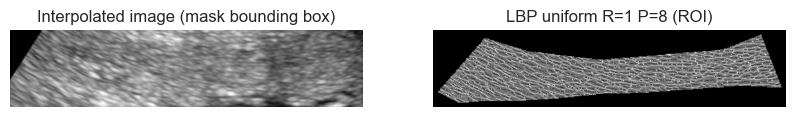

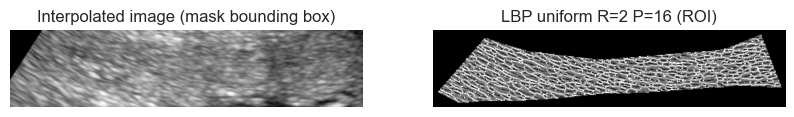

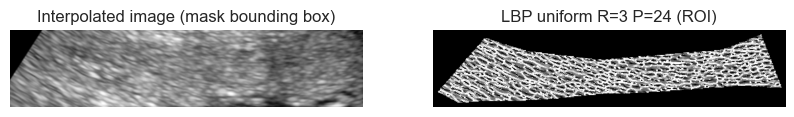

{'LBP_R_1_P_8_Energy': 0.2604189800816434,
 'LBP_R_1_P_8_Entropy': 2.5247588957060403,
 'LBP_R_1_P_8_Hist_1': 0.0080499180100772,
 'LBP_R_1_P_8_Hist_2': 0.0419106842429416,
 'LBP_R_1_P_8_Hist_3': 0.040632919479437285,
 'LBP_R_1_P_8_Hist_4': 0.12292097024911532,
 'LBP_R_1_P_8_Hist_5': 0.46029345997303855,
 'LBP_R_1_P_8_Hist_6': 0.14577166343645084,
 'LBP_R_1_P_8_Hist_7': 0.05873458696241511,
 'LBP_R_1_P_8_Hist_8': 0.05543369465669563,
 'LBP_R_1_P_8_Hist_9': 0.03273207402510226,
 'LBP_R_1_P_8_Hist_10': 0.033520028962596586,
 'LBP_R_2_P_16_Energy': 0.09348242830480769,
 'LBP_R_2_P_16_Entropy': 3.806782340538647,
 'LBP_R_2_P_16_Hist_1': 0.020934046042079064,
 'LBP_R_2_P_16_Hist_2': 0.0234895755690877,
 'LBP_R_2_P_16_Hist_3': 0.03735332325310954,
 'LBP_R_2_P_16_Hist_4': 0.04648934131216541,
 'LBP_R_2_P_16_Hist_5': 0.04056903124126207,
 'LBP_R_2_P_16_Hist_6': 0.03626722320413087,
 'LBP_R_2_P_16_Hist_7': 0.03805609387303691,
 'LBP_R_2_P_16_Hist_8': 0.09723789850267854,
 'LBP_R_2_P_16_Hist_9':

In [245]:
lbp_features_extractor(image, mask, plot=True)

## Extract features

In [247]:
def extract_features(input_csv, image_path, settings_name, verbosity=1):
    settings = os.path.join('./', settings_name)
    
    if verbosity>0:
        radiomics.setVerbosity(logging.INFO)
    try:
        with open(input_csv, 'r') as inFile:
          cr = csv.DictReader(inFile, lineterminator='\n')
          cases = []
          for row_idx, row in enumerate(cr, start=1):
            cases.append(row)
    except Exception:
        logger.error('CSV READ FAILED', exc_info=True)
        
    if os.path.isfile(settings):
        extractor = featureextractor.RadiomicsFeatureExtractor(settings)
    else: 
        logger.error('SETTINGS READ FAILED')
        exit(-1)
    
    features = []
    for case in cases:
        try:
          feature_vector = OrderedDict(case)
       
          patient_folder = os.path.join(image_path, str(case['Record ID']))
          dicom_path = os.path.join(patient_folder, case['Image'])
          mask_path = os.path.join(patient_folder, os.path.splitext(os.path.basename(dicom_path))[0] + '_mask.png')
    
          image_3d = sitk.ReadImage(dicom_path, sitk.sitkUInt8)
          mask = plt.imread(mask_path).astype(np.uint8)
          mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
          mask_eroded = erode_mask(mask)
          mask_2d = sitk.GetImageFromArray(mask_eroded) 
          mask_3d = sitk.JoinSeries(mask_2d)
          mask_3d.SetSpacing(image_3d.GetSpacing())
            
          # pyradiomic features  
          feature_vector.update(extractor.execute(image_3d, mask_3d))
          
          # Energy, entropy and LBP histogram
          _, _image, _mask = preprocess(image_3d, mask_3d)
          feature_vector.update(lbp_features_extractor(_image, _mask))
      
          features.append(feature_vector)
         
          logger.info('Patient %s image %s',case['Record ID'], case['Image'])      
        except Exception:
              logger.error('Feature extraction failed', exc_info=True)
            
       
    return features

In [ ]:
features = extract_features('../data/samples.csv', ANTERIOR_PATIENTS_PATH, 'settings_1.yaml')

249.98966019342993
105.11329161393552


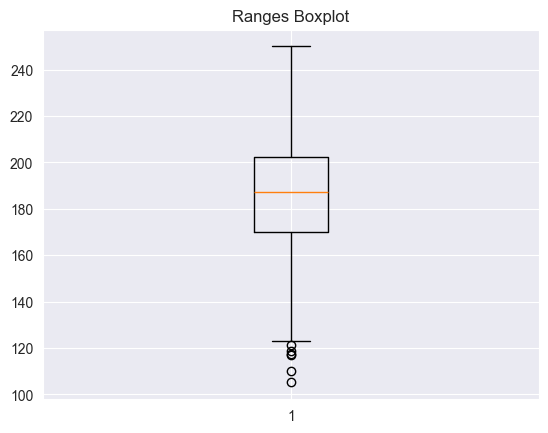

In [249]:
ranges = [r['original_firstorder_Range'] for r in features]
print(np.max(ranges))
print(np.min(ranges))

plt.boxplot(ranges)
plt.title('Ranges Boxplot')
plt.show()

With a bin width = 2 we have a range of 50-127 bins (which is inside the rank recommended by pyradiomics).

# +-3sigma normalization

In [114]:
def get_mask_example(path):
    mask_image = plt.imread(path).astype(np.uint8)
    if len(mask_image.shape) == 3:
        mask_image = cv2.cvtColor(mask_image, cv2.COLOR_RGB2GRAY)
    
    return mask_image


def get_image_example(path):
    dicom_image = pydicom.dcmread(path)
    image_data =  cv2.cvtColor(dicom_image.pixel_array, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    
    return image_data
    

def normalize_image_intensity(image, mask, resegment=False, k=8):
    """
    Normalize ROI to +-3sigma and quantize the intensity level in k bits
    :param image: 2D array image
    :param mask: 2D array image
    :param resegment: if True normalize ROI to +-3sigma (not using the pixels outside that range) 
    :param k: number of image bits per pixel after normalization
    :return: normalized 1D and 2D ROI image
    """
   
    roi1d, _ = crop_image(image, mask)
    mu = np.mean(roi1d)  
    sigma = np.std(roi1d) 
    # minimum normalized value
    min_norm = mu - 3 * sigma
    # maximum normalized value
    max_norm = mu + 3 * sigma
    max_val = (2**k) - 1
    
    if resegment:
        print('resegment True')
        indices = np.where((roi1d >= min_norm) & (roi1d <= max_norm))  
        roi1d_filtered = roi1d[indices]
    
        N = np.round(((roi1d_filtered - min_norm) / (max_norm - min_norm)) * max_val).astype(int)
        roi1d_norm = np.clip(N, 0, max_val)
        roi2d_norm = np.zeros_like(image, dtype=int)
        mask_indices = np.argwhere(mask)
    
        for idx, val in zip(mask_indices[indices], N):
            roi2d_norm[idx[0], idx[1]] = val
     
    else:
        N = np.round(((roi1d - min_norm) / (max_norm - min_norm)) * max_val).astype(int)
       
        roi1d_norm = np.clip(N, 0, max_val)
        
        roi2d_norm = np.zeros_like(mask, dtype=int)
        mask_bool = mask.astype(bool)
        roi2d_norm[mask_bool] = roi1d_norm
    
    return roi1d_norm, roi2d_norm



resegment True


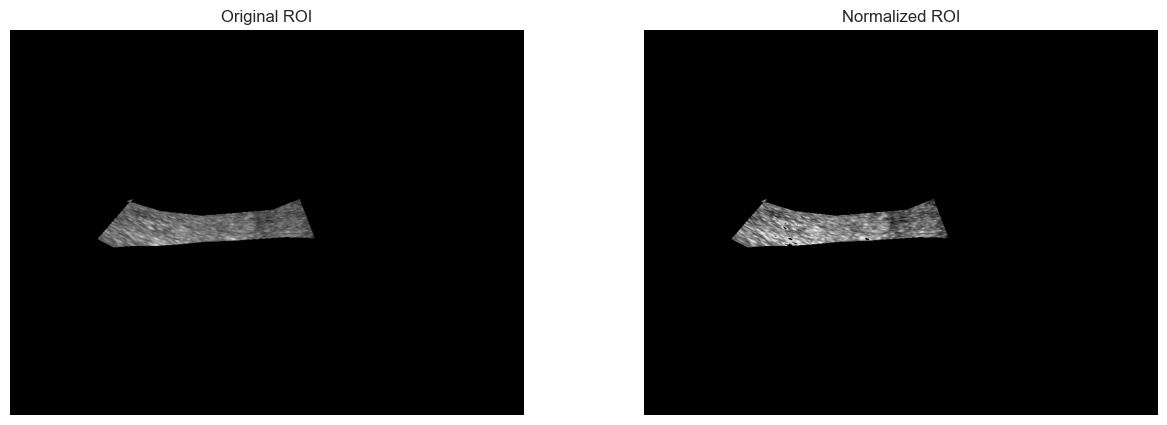

In [250]:
patient = 12
mask_data = get_mask_example(ANTERIOR_PATIENTS_PATH+'\\'+str(patient)+'\\IMG_20220913_1_1_mask.png')
image_data = get_image_example(ANTERIOR_PATIENTS_PATH+'\\'+str(patient)+'\\IMG_20220913_1_1.dcm')

roi1d, roi2d = crop_image(image_data, mask_data)
roi1d_norm, roi2d_norm = normalize_image_intensity(image_data, mask_data, resegment=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(roi2d, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original ROI')
ax[0].axis('off') 
ax[1].imshow(roi2d_norm, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Normalized ROI')
ax[1].axis('off') 

plt.show()

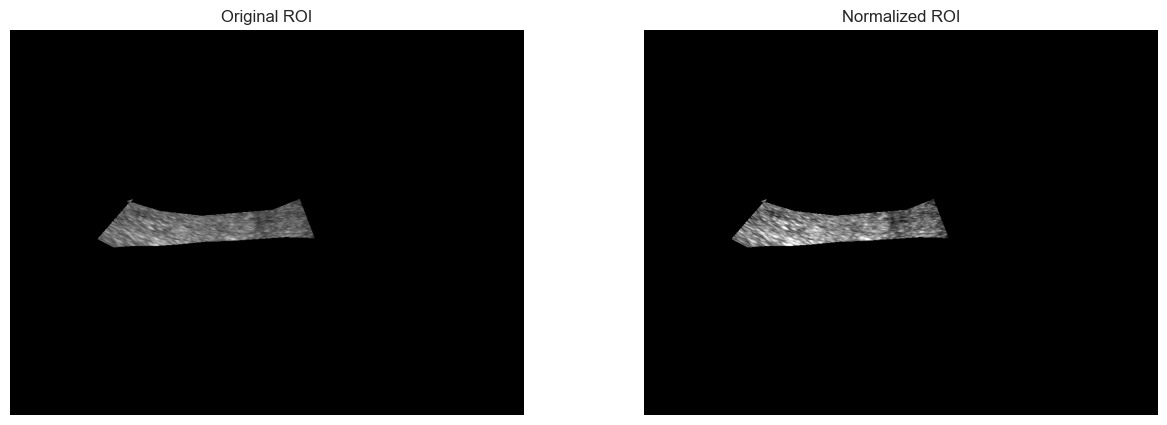

In [251]:
patient = 12
mask_data = get_mask_example(ANTERIOR_PATIENTS_PATH+'\\'+str(patient)+'\\IMG_20220913_1_1_mask.png')
image_data = get_image_example(ANTERIOR_PATIENTS_PATH+'\\'+str(patient)+'\\IMG_20220913_1_1.dcm')

roi1d, roi2d = crop_image(image_data, mask_data)
roi1d_norm, roi2d_norm = normalize_image_intensity(image_data, mask_data, False, 7)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(roi2d, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original ROI')
ax[0].axis('off') 
ax[1].imshow(roi2d_norm, cmap='gray', vmin=0, vmax=127)
ax[1].set_title('Normalized ROI')
ax[1].axis('off') 

plt.show()

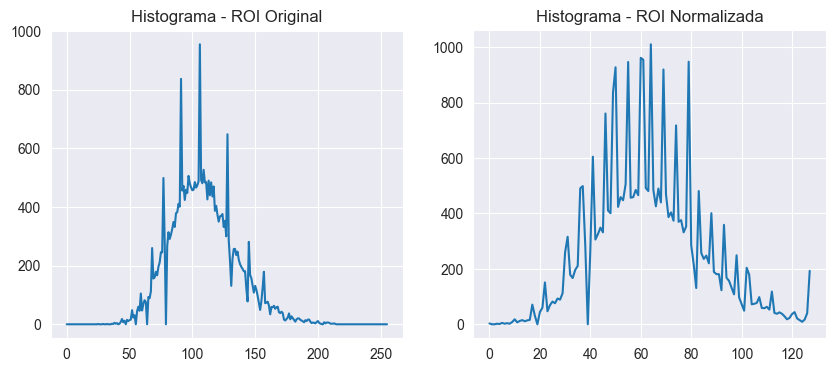

In [252]:
hist_original, bins_original = np.histogram(roi1d, bins=256, range=[0,255])
hist_normalized, bins_normalized = np.histogram(roi1d_norm, bins=128, range=[0,127])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_original)
plt.title('Histograma - ROI Original')


plt.subplot(1, 2, 2)
plt.plot(hist_normalized)
plt.title('Histograma - ROI Normalizada')

plt.show()

In [115]:
def normalized_3sigma(image, mask, resegment=False, k=8):
    """
    Normalize with 3sigma normalization mapping the intensities to [mu-3sigma, mu+3sigma]
    :param resegment: if True normalize ROI to +-3sigma (not using the pixels outside that range) 
    :param k: k bits for quantification
    :return:  1D array masked image, 2D array masked image with 0 grey level value in non-ROI pixels
    """

    return normalize_image_intensity(image, mask, resegment, k), mask

In [116]:
def glh_features(image, Ng=256):
    """
    Compute first order features of the image from the normalized histogram (for independence of the image size)
    :param image: 1D array image
    :return: feature dictionary (Mean,Variance,Skewness,Kurtosis,Energy,Entropy,10Percentile,25Percentile,50Percentile,75Percentile,90Percentile)

    """
    glh_features = {}
       
    histogram, bin_edges = np.histogram(image, bins=Ng, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    glh_features["GLH_Mean"] =  np.sum(bin_centers * histogram)
    glh_features["GLH_Variance"] = np.sum((bin_centers - glh_features["GLH_Mean"])**2 * histogram)
    glh_features["GLH_Skewness"] =  np.sum((bin_centers - glh_features["GLH_Mean"])**3 * histogram) / (np.sqrt(glh_features["GLH_Variance"]) ** 3)
    glh_features["GLH_Kurtosis"] =  (np.sum((bin_centers - glh_features["GLH_Mean"])**4 * histogram) / (np.sqrt(glh_features["GLH_Variance"]) ** 4)) - 3
    glh_features["GLH_Energy"] = np.sum(histogram ** 2)
    glh_features["GLH_Entropy"] = -np.sum(histogram * np.log2(histogram + 1e-9))
    glh_features["GLH_10Percentile"] =  np.percentile(image, 10)
    glh_features["GLH_25Percentile"] =  np.percentile(image, 25)
    glh_features["GLH_50Percentile"] =  np.percentile(image, 50) # Median
    glh_features["GLH_75Percentile"] =  np.percentile(image, 75)
    glh_features["GLH_90Percentile"] = np.percentile(image,90) 
    
    return glh_features

In [117]:
import mahotas


def glcm_features(image):
    """
    Compute first 13 features Haralick's features of the image. These features are calculated over the GLCM normalized, it means it is a probability matrix where every element is the occurrence probability of a pixel pair intensity levels. So the features are 
    independent of the number of pair of pixels.
    :param image: 2D array image with 0 grey level in non-ROI pixels and any 0 grey level in ROI pixels.
    :return: features dictionary for 5 distances (1, 2, 3, 4, 5) (averaged in four directions 0º, 45º, 90º, 135º)
    """
    haralick_features = {}
    distances = [1, 2, 3, 4, 5]
 
    haralick_labels = [
        'GLCM_Angular_Second_Moment',
        'GLCM_Contrast',
        'GLCM_Correlation',
        'GLCM_Sum_of_Squares',
        'GLCM_Inverse_Difference_Moment',
        'GLCM_Sum_Average',
        'GLCM_Sum_Variance',
        'GLCM_Sum_Entropy',
        'GLCM_Entropy',
        'GLCM_Difference_Variance',
        'GLCM_Difference_Entropy',
        'GLCM_Information_Measure_of_Correlation1',
        'GLCM_Information_Measure_of_Correlation2'
    ]

    for distance in distances:
        # if ignore zeros the first row and column of the GLCM is ignored (all changes of grey level involving the 0 level -out the ROI- are ignored)
        features = mahotas.features.haralick(image, distance=distance, ignore_zeros=True, return_mean = True)
        for j, label in enumerate(haralick_labels):
            haralick_features[f'{label}_d{distance}'] = features[j]

    return haralick_features

In [118]:
"""
==============================================================================
@author: Nikolaos Giakoumoglou
@author: https://github.com/eiproject/lib-GLRLM-Python3/blob/master/lib-GLRLM/libpreprocessing.py
@author: https://github.com/szhHr/Gray-Level-Run-Length-Matrix-to-get-image-feature/blob/master/GrayRumatrix.py
==============================================================================
"""
    
import numpy as np

def glrlm_0(f, grayLevel=5, runLength=5, skipFirstRow=True):
    degree0Matrix = np.zeros([grayLevel, runLength])
    counter = 0
    for y in range(f.shape[0]):
        for x in range(f.shape[1]):   
            nowVal = f[y][x]
            if x + 1 >= f.shape[1]:
                nextVal = None
            else:
                nextVal = f[y][x + 1]
            if nextVal != nowVal and counter == 0:
                degree0Matrix[int(nowVal)][counter] += 1
            elif nextVal == nowVal:
                counter += 1
            elif nextVal != nowVal and counter != 0:
                degree0Matrix[int(nowVal)][counter] += 1
                counter = 0
    return degree0Matrix[1:,:] if skipFirstRow else degree0Matrix

def glrlm_90(f, grayLevel=5, runLength=5, skipFirstRow=True):
    degree90Matrix = np.zeros([grayLevel, runLength])
    counter = 0
    for x in range(f.shape[1]):
        for y in range(f.shape[0]):
            nowVal = f[y][x]
            if y + 1 >= f.shape[0]:
                nextVal = None
            else:
                nextVal = f[y + 1][x]
            if nextVal != nowVal and counter == 0:
                degree90Matrix[int(nowVal)][counter] += 1
            elif nextVal == nowVal:
                counter += 1
            elif nextVal != nowVal and counter != 0:
                degree90Matrix[int(nowVal)][counter] += 1
                counter = 0
    return degree90Matrix[1:,:] if skipFirstRow else degree90Matrix

def glrlm_45(f, grayLevel=5, runLength=5, skipFirstRow=True):
    degree45Matrix = np.zeros([grayLevel, runLength])
    for y in range(f.shape[0]):
        counter = 0
        i_range = max(f.shape)
        for i in range(i_range):
            y1 = y - i
            if i >= f.shape[1] or y1 < 0:
                break
            else:
                nowVal = f[y1][i]
            if y1 - 1 < 0 or i + 1 >= f.shape[1]:
                nextVal = None
            else:
                nextVal = f[y1 - 1][i + 1]
            if nextVal != nowVal and counter == 0:
                degree45Matrix[int(nowVal)][counter] += 1
            elif nextVal == nowVal:
                counter += 1
            elif nextVal != nowVal and counter != 0:
                degree45Matrix[int(nowVal)][counter] += 1
                counter = 0
    for x in range(f.shape[1]):
        if x == f.shape[1] - 1:
            break
        counter = 0
        i_range = max(f.shape)
        for i in range(i_range):
            y_i = -1 - i
            x_i = -1 + i - x
            if x_i >= 0 or y_i <= -1 - f.shape[0]:
                break
            else:
                nowVal = f[y_i][x_i]
            if y_i - 1 <= -(f.shape[0] + 1) or x_i + 1 >= 0:
                nextVal = None
            else:
                nextVal = f[y_i - 1][x_i + 1]
            if nextVal != nowVal and counter == 0:
                degree45Matrix[int(nowVal)][counter] += 1
            elif nextVal == nowVal:
                counter += 1
            elif nextVal != nowVal and counter != 0:
                degree45Matrix[int(nowVal)][counter] += 1
                counter = 0
    degree45Matrix[0,1:] = 0
    return degree45Matrix[1:,:] if skipFirstRow else degree45Matrix

def glrlm_135(f, grayLevel=5, runLength=5, skipFirstRow=True):
    degree135Matrix = np.zeros([grayLevel, runLength])
    for y in range(f.shape[0]):
        counter = 0
        i_range = max(f.shape)
        for i in range(i_range):
            y1 = y + i
            if y1 >= f.shape[0] or i >= f.shape[1]:
                break
            else:
                nowVal = f[y1][i]
                if y1 >= f.shape[0] - 1 or i >= f.shape[1] - 1:
                    nextVal = None
                else:
                    nextVal = f[y1 + 1][i + 1]
                if nextVal != nowVal and counter == 0:
                    degree135Matrix[int(nowVal)][counter] += 1
                elif nextVal == nowVal:
                    counter += 1
                elif nextVal != nowVal and counter != 0:
                    degree135Matrix[int(nowVal)][counter] += 1
                    counter = 0
    for x in range(f.shape[1]):
        if x == 0:
            continue
        i_range = max(f.shape)
        counter = 0
        for i in range(i_range):
            x1 = x + i
            if i >= f.shape[0] or x1 >= f.shape[1]:
                break
            else:
                nowVal = f[i][x1]
            if i >= f.shape[0] - 1 or x1 >= f.shape[1] - 1:
                nextVal = None
            else:
                nextVal = f[i + 1][x1 + 1]
            if nextVal != nowVal and counter == 0:
                degree135Matrix[int(nowVal)][counter] += 1
            elif nextVal == nowVal:
                counter += 1
            elif nextVal != nowVal and counter != 0:
                degree135Matrix[int(nowVal)][counter] += 1
                counter = 0
    degree135Matrix[0,1:] = 0
    return degree135Matrix[1:,:] if skipFirstRow else degree135Matrix

def _apply_over_degree(function, x1, x2):
    if function == np.divide:
        x2 = x2 + 1e-16
    rows, cols, nums = x1.shape
    result = np.ndarray((rows, cols, nums))
    for i in range(nums):
        result[:, :, i] = function(x1[:, :, i], x2)
        result[result == np.inf] = 0
        result[np.isnan(result)] = 0
    return result 
    
def _calculate_ij (rlmatrix):
    gray_level, run_length, _ = rlmatrix.shape
    I, J = np.ogrid[0:gray_level, 0:run_length]
    return I, J+1
    
def _calculate_s(rlmatrix):
    return np.apply_over_axes(np.sum, rlmatrix, axes=(0, 1))[0, 0]

def _glrlm(f, Ng=256):   
    '''
    Parameters
    ----------
    f : numpy ndarray
        Image of dimensions N1 x N2.
    mask : numpy ndarray
        Mask image N1 x N2 with 1 if pixels belongs to ROI, 0 else.
    Ng : int, optional
        Image number of gray values. The default is 256.

    Returns
    -------
    mat : numpy ndarray
        GLRL Matrices for 0, 45, 90 and 135 degrees.
    '''
    runLength = max(f.shape)
    mat0 = glrlm_0(f, grayLevel=Ng, runLength=runLength)
    mat45 = glrlm_45(f, grayLevel=Ng, runLength=runLength)
    mat90 = glrlm_90(f, grayLevel=Ng, runLength=runLength)
    mat135 = glrlm_135(f, grayLevel=Ng, runLength=runLength)            
    mat = np.dstack((mat0, mat45, mat90, mat135))      
    return mat

def my_glrlm_features(f, Ng=256):
    '''
    Parameters
    ----------
    f : numpy ndarray
        Image of dimensions N1 x N2.
    Ng : int, optional
        Image number of gray values. The default is 256.

    Returns
    -------
    features : numpy ndarray
        1)Short Run Emphasis, 2)Long Run Emphasis, 3)Gray Level 
        Non-Uniformity/Gray Level Distribution, 4)Run Length 
        Non-Uniformity/Run Length Distribution, 5)Run Percentage,
        6)Low Gray Level Run Emphasis, 7)High Gray Level Run Emphasis,
        8)Short Low Gray Level Emphasis, 9)Short Run High Gray Level 
        Emphasis, 10)Long Run Low Gray Level Emphasis, 11)Long Run 
        High Gray Level Emphasis.
    labels : list
        Labels of features.
    '''
        
    labels = ["GLRLM_ShortRunEmphasis",
              "GLRLM_LongRunEmphasis",
              "GLRLM_GrayLevelNonUniformity",
              "GLRLM_GrayLevelNonUniformity_Norm",
              "GLRLM_RunLengthNonUniformity",
              "GLRLM_RunLengthNonUniformity_Norm",
              "GLRLM_RunPercentage",
              "GLRLM_LowGrayLevelRunEmphasis",
              "GLRLM_HighGrayLevelRunEmphasis",
              "GLRLM_ShortLowGrayLevelEmphasis",
              "GLRLM_ShortRunHighGrayLevelEmphasis",
              "GLRLM_LongRunLowGrayLevelEmphasis",
              "GLRLM_LongRunHighGrayLevelEmphasis"]
    
    rlmatrix = _glrlm(f, Ng)
  
    I, J = _calculate_ij(rlmatrix)
    S = _calculate_s(rlmatrix)
    G = np.apply_over_axes(np.sum, rlmatrix, axes=1)
    R = np.apply_over_axes(np.sum, rlmatrix, axes=0)
        
    features = np.zeros(13,np.double)
    features[0] = ((np.apply_over_axes(np.sum, _apply_over_degree(np.divide, rlmatrix, (J*J)), axes=(0, 1))[0, 0])/S).mean()
    features[1] = ((np.apply_over_axes(np.sum, _apply_over_degree(np.multiply, rlmatrix, (J*J)), axes=(0, 1))[0, 0])/S).mean()
    features[2] = ((np.apply_over_axes(np.sum, (G*G), axes=(0, 1))[0, 0])/S).mean()
    features[3] = ((np.apply_over_axes(np.sum, (G*G), axes=(0, 1))[0, 0])/(S*S)).mean()
    features[4] = ((np.apply_over_axes(np.sum, (R*R), axes=(0, 1))[0, 0])/S).mean()
    features[5] = ((np.apply_over_axes(np.sum, (R*R), axes=(0, 1))[0, 0])/(S*S)).mean()
        
    features[6] = (S / np.apply_over_axes(np.sum, _apply_over_degree(np.multiply, rlmatrix, J), axes=(0, 1))[0, 0]).mean()
    features[7]= ((np.apply_over_axes(np.sum, _apply_over_degree(np.divide, rlmatrix, (I*I)), axes=(0, 1))[0, 0])/S).mean()
    features[8] = ((np.apply_over_axes(np.sum, _apply_over_degree(np.multiply, rlmatrix, (I*I)), axes=(0, 1))[0, 0])/S).mean()
    features[9] = ((np.apply_over_axes(np.sum, _apply_over_degree(np.divide, rlmatrix, (I*I*J*J)), axes=(0, 1))[0, 0])/S).mean()
         
    temp = _apply_over_degree(np.multiply, rlmatrix, (I*I))
    features[10] = ((np.apply_over_axes(np.sum, _apply_over_degree(np.divide, temp, (J*J)), axes=(0, 1))[0, 0])/S).mean()
        
    temp = _apply_over_degree(np.multiply, rlmatrix, (J*J))
    features[11] = ((np.apply_over_axes(np.sum, _apply_over_degree(np.divide, temp, (I*I)), axes=(0, 1))[0, 0])/S).mean()
    features[12] = ((np.apply_over_axes(np.sum, _apply_over_degree(np.multiply, rlmatrix, (I*I*J*J)), axes=(0, 1))[0, 0])/S).mean()
        
    return features, labels    

In [119]:
def glrm_features(image):
    """
    Compute gray level run length features without the information of non-ROI pixels. The features are calculated over the normalized GLRM and not including the first row, it means every feature is independent of the total number of runs and does not take into account 0 grey levels.
    :param image: 2D array masked image with 0 grey level in non-ROI pixels and greater than 0 grey level in ROI pixels.
    :return: dictionary features derived averaged accross four directions (Oº, 45º, 90°, 135º): 
    Shortrun emphasis, Long-run emphasis, Grey-level non-uniformity, Grey-level non-uniformity normalized, Run-length non-uniformity, Run-length non-uniformity normalized, RunPercentage, LowGrayLevelRunEmphasis, HighGrayLevelRunEmphasis, ShortLowGrayLevelEmphasis, ShortRunHighGrayLevelEmphasis, LongRunLowGrayLevelEmphasis, LongRunHighGrayLevelEmphasis
    """
    
    levels = np.max(image)+1
    features, labels = my_glrlm_features(image, Ng=levels)

    return dict(zip(labels, features))

In [120]:
def mark_non_roi_pixels(image, mask):
    """
    Changes the grey levels for setting the non-ROI pixels with the -1 value
    :param image: 2D array image
    :param mask: 2D array image
    :return: 2D array image with -1 in non-roi pixels and an increment of one in the grey levels of ROI pixels
    """

    roi2d_marked = image.copy().astype(np.int32)
    roi2d_marked[mask==0] = -1
    roi2d_marked = (roi2d_marked + 1).astype(np.int16)
   
    return roi2d_marked

In [121]:
def has_zero_values(image):
    """
    Check if an imame have 0 grey level pixel intensity to control the zero introduces with the +-3 sigma normalization
    :param image: 1D array image
    :return: boolean True if the image has zero grey level intensity
    """

    return (image == 0).any() 

In [122]:
def my_feature_extractor(input_csv, image_path, normalized_image, resegment=False, k=8):
    """
    Creates the dataset with the features from the images 
    :param input_csv: csv with samples
    :param normalized_image: if True normalize images with +/-3 sigma normalization
    :param k: k bits for quantification. Default 8.
    :return: dataframe with patient id, file, label and features
    """
   
    try:
        with open(input_csv, 'r') as inFile:
          cr = csv.DictReader(inFile, lineterminator='\n')
          cases = []
          for row_idx, row in enumerate(cr, start=1):
            cases.append(row)
    except Exception:
        logger.error('CSV READ FAILED', exc_info=True)
        
    feature_list = []    
    
    for case in cases:
         
         patient_folder = os.path.join(image_path, str(case['Record ID']))
         dicom_path = os.path.join(patient_folder, case['Image'])
         mask_path = os.path.join(patient_folder, os.path.splitext(os.path.basename(dicom_path))[0] + '_mask.png')

         (roi1d, roi2d), mask, size = get_roi(dicom_path, mask_path, normalized_image, resegment, k)
         
         if has_zero_values(roi1d):
              roi2d_marked = mark_non_roi_pixels(roi2d, mask)
              features_glcm = glcm_features(roi2d_marked)
              features_glrm = glrm_features(roi2d_marked)
         else:
              features_glcm = glcm_features(roi2d)
              features_glrm = glrm_features(roi2d)

         features_glh = glh_features(roi1d)
         features_lbp = lbp_features_extractor(roi2d, mask)

         features = {**case, **features_glh, **features_glcm,  **features_glrm,  **features_lbp}
         feature_list.append(features)
              
    return pd.DataFrame(feature_list)

In [ ]:
my_df = my_feature_extractor('../data/samples_filtered.csv', ANTERIOR_PATIENTS_PATH, normalized_image=False)

In [ ]:
my_df.to_csv('../data/anterior/my_df_3sigma_raw.csv', index=False)

In [ ]:
my_df = my_feature_extractor('../data/samples_fgr_filtered.csv', ANTERIOR_PATIENTS_PATH, normalized_image=False)

In [ ]:
my_df.to_csv('../data/anterior/my_df_3sigma_fgr_raw.csv', index=False)

In [ ]:
my_df = my_feature_extractor('../data/samples_pe_filtered.csv', ANTERIOR_PATIENTS_PATH, normalized_image=False)

In [ ]:
my_df.to_csv('../data/anterior/my_df_3sigma_pe_raw.csv', index=False)

In [ ]:
my_df = my_feature_extractor('../data/samples_fgr_filtered.csv', ANTERIOR_PATIENTS_PATH, normalized_image=True, k=8)

In [ ]:
my_df.to_csv('../data/anterior/my_df_3sigma_8_fgr.csv', index=False)

In [ ]:
def my_feature_lbp_extractor(input_csv, image_path):
    """
    Creates the dataset with the LBP features from the images 
    :param input_csv: csv with samples
    :return: dataframe with patient id, file, label and features
    """
   
    try:
        with open(input_csv, 'r') as inFile:
          cr = csv.DictReader(inFile, lineterminator='\n')
          cases = []
          for row_idx, row in enumerate(cr, start=1):
            cases.append(row)
    except Exception:
        logger.error('CSV READ FAILED', exc_info=True)
        
    feature_list = []    
    
    for case in cases:
         
         patient_folder = os.path.join(image_path, str(case['Record ID']))
         dicom_path = os.path.join(patient_folder, case['Image'])
         mask_path = os.path.join(patient_folder, os.path.splitext(os.path.basename(dicom_path))[0] + '_mask.png')

         (roi1d, roi2d), mask, size = get_roi(dicom_path, mask_path, False, False)
 
         features_lbp = lbp_features_extractor(roi2d, mask)

         features = {**case, **features_lbp}
         feature_list.append(features)
              
    return pd.DataFrame(feature_list)

In [ ]:
lbp = my_feature_lbp_extractor('../data/samples_filtered.csv', ANTERIOR_PATIENTS_PATH)

In [ ]:
lbp.to_csv('../data/anterior/lbp.csv', index=False)

In [ ]:
lbp_pe = my_feature_lbp_extractor('../data/samples_pe_filtered.csv', ANTERIOR_PATIENTS_PATH)

In [ ]:
lbp_pe.to_csv('../data/anterior/lbp_pe.csv', index=False)

In [ ]:
lbp_fgr = my_feature_lbp_extractor('../data/samples_fgr_filtered.csv', ANTERIOR_PATIENTS_PATH)

In [ ]:
lbp_fgr.to_csv('../data/anterior/lbp_fgr.csv', index=False)

In [ ]:
lbp_fgr = my_feature_lbp_extractor('../data/samples_val_fgr_filtered.csv', VAL_ANTERIOR_PATIENTS_PATH)

In [ ]:
lbp_fgr.to_csv('../data/anterior/lbp_val_fgr.csv', index=False)

In [ ]:
def my_feature_extractor_with_interpolation(input_csv, image_path, k=8):
    """
    Creates the dataset with the features from the images 
    :param input_csv: csv with samples
    :param normalized_image: if True normalize images with +/-3 sigma normalization
    :param erode: if True erode mask. Default True
    :param k: k bits for quantification. Default 8.
    :return: dataframe with patient id, file, label and features
    """
   
    try:
        with open(input_csv, 'r') as inFile:
          cr = csv.DictReader(inFile, lineterminator='\n')
          cases = []
          for row_idx, row in enumerate(cr, start=1):
            cases.append(row)
    except Exception:
        logger.error('CSV READ FAILED', exc_info=True)
        
    feature_list = []    
    
    for case in cases:
        try:
         patient_folder = os.path.join(image_path, str(case['Record ID']))
         dicom_path = os.path.join(patient_folder, case['Image'])
         mask_path = os.path.join(patient_folder, os.path.splitext(os.path.basename(dicom_path))[0] + '_mask.png')
         image_3d = sitk.ReadImage(dicom_path, sitk.sitkUInt8)
         mask = plt.imread(mask_path).astype(np.uint8)
         mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
         mask_eroded = erode_mask(mask)
         mask_2d = sitk.GetImageFromArray(mask_eroded) 
         mask_3d = sitk.JoinSeries(mask_2d)
         mask_3d.SetSpacing(image_3d.GetSpacing())
         
         m, _image, _mask = preprocess(image_3d, mask_3d)
         (roi1d, roi2d), mask = normalized_3sigma(_image, _mask, False, k)
       
         if has_zero_values(roi1d):
              roi2d_marked = mark_non_roi_pixels(roi2d, mask)
              features_glcm = glcm_features(roi2d_marked)
              features_glrm = glrm_features(roi2d_marked)
         else:
              features_glcm = glcm_features(roi2d)
              features_glrm = glrm_features(roi2d)

         features_glh = glh_features(roi1d)
         features_lbp = lbp_features_extractor(roi2d, mask)

         features = {**case, **features_glh, **features_glcm,  **features_glrm,  **features_lbp}
         feature_list.append(features)

        except Exception:
            logger.error('Error', exc_info=True)

    return feature_list

In [ ]:
my_df2 = my_feature_extractor_with_interpolation('../data/samples.csv', ANTERIOR_PATIENTS_PATH, k=7)

In [ ]:
pd.DataFrame(my_df2).to_csv('../data/anterior/my_df_3sigma_7_int.csv', index=False)

In [ ]:
my_df3 = my_feature_extractor_with_interpolation('../data/samples_fgr.csv', ANTERIOR_PATIENTS_PATH, k=7)

In [ ]:
pd.DataFrame(my_df3).to_csv('../data/anterior/my_df_3sigma_7_int_fgr.csv', index=False)

In [ ]:
my_df4 = my_feature_extractor_with_interpolation('../data/samples_pe.csv', ANTERIOR_PATIENTS_PATH, k=7)

In [ ]:
pd.DataFrame(my_df4).to_csv('../data/anterior/my_df_3sigma_7_int_pe.csv', index=False)

## Concat lbp to pyradiomics features
When not using interpolation we do it manually

In [ ]:
df_lbp_norm = pd.read_csv('../data/anterior/lbp_fgr_norm.csv')
features_5_norm= pd.read_csv('../data/anterior/features_5_fgr_pix_norm.csv')

In [ ]:
df_lbp = pd.concat([features_5_norm, df_lbp_norm.filter(like='LBP')], axis=1)
df_lbp.to_csv('../data/anterior/features_5_fgr_lbp_pix_norm.csv', index=False)

In [ ]:
df_lbp_norm = pd.read_csv('../data/anterior/lbp_val_fgr_norm.csv')
features_5_norm= pd.read_csv('../data/anterior/features_5_fgr_val_pix_norm.csv')

In [ ]:
df_lbp = pd.concat([features_5_norm, df_lbp_norm.filter(like='LBP')], axis=1)
df_lbp.to_csv('../data/anterior/features_5_lbp_val_fgr_pix_norm.csv', index=False)

## Posterior images

In [ ]:
my_df_p = my_feature_extractor('../data/samples_posterior_filtered.csv', POSTERIOR_PATIENTS_PATH, normalized_image=True, resegment=False, k=7)

In [ ]:
my_df_p.to_csv('../data/posterior/my_df_3sigma_7.csv', index=False)

## All images

In [ ]:
lbp_all = my_feature_lbp_extractor('../data/samples_fgr_all_filtered.csv', ALL_PATIENTS_PATH)

In [ ]:
lbp_all.to_csv('../data/all/lbp_fgr.csv', index=False)

In [ ]:
my_df_all = my_feature_extractor('../data/samples_fgr_all_filtered.csv', ALL_PATIENTS_PATH, normalized_image=True, resegment=False, k=7)
my_df_all.to_csv('../data/all/my_df_3sigma_7_fgr_all.csv', index=False)

In [ ]:
my_df_all = my_feature_extractor('../data/samples_fgr_all_filtered.csv', ALL_PATIENTS_PATH, normalized_image=False)

In [ ]:
my_df_all.to_csv('../data/all/my_df_3sigma_raw_fgr.csv', index=False)

# Upsampling with posterior images 
Maybe we achieve better results adding the best posterior images (same number of imagenes for 1 and 0 label) to the anterior dataset. But we will have to generate all the csv features file for this images if we don't have created the posterior file already.

In [253]:
best_post_images_1 = [17, 54, 65, 77, 98, 105, 109, 117, 142, 171, 179, 232, 234, 240, 275, 277, 306, 308, 312, 329]

In [ ]:
filtered_df_post = df_posterior[df_posterior['Record ID'].isin(best_post_images_1)]
len(filtered_df_post)

In [ ]:
best_post_images_0 = [84, 101, 126, 145, 182, 202, 210, 233, 236, 250, 251, 256, 260, 263, 264, 273,  289, 297, 344, 347]

In [ ]:
filtered_df_post_0 = df_posterior[df_posterior['Record ID'].isin(best_post_images_0)]
len(filtered_df_post_0)

In [ ]:
best_post = pd.read_csv('../data/posterior/features_1_pix_norm.csv')
filtered_best_post_1 = best_post[best_post['Record ID'].isin(best_post_images_1)]
filtered_best_post_0 = best_post[best_post['Record ID'].isin(best_post_images_0)]
df_post_best = pd.concat([filtered_best_post_1, filtered_best_post_0], ignore_index=True)
anterior = pd.read_csv('../data/anterior/features_1_pix_norm.csv')
output = pd.concat([df_post_best, anterior], ignore_index=True)
output.to_csv('../data/both/features_1_pix_norm.csv', index=False)

In [ ]:
plot_bars(output,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
best_post = pd.read_csv('../data/posterior/features_2_pix_norm.csv')
filtered_best_post_1 = best_post[best_post['Record ID'].isin(best_post_images_1)]
filtered_best_post_0 = best_post[best_post['Record ID'].isin(best_post_images_0)]
df_post_best = pd.concat([filtered_best_post_1, filtered_best_post_0], ignore_index=True)
anterior = pd.read_csv('../data/anterior/features_2_pix_norm.csv')
output = pd.concat([df_post_best, anterior], ignore_index=True)
output.to_csv('../data/both/features_2_pix_norm.csv', index=False)

In [ ]:
plot_bars(output,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
best_post = pd.read_csv('../data/posterior/features_2_pix_norm.csv')
filtered_best_post_1 = best_post[best_post['Record ID'].isin(best_post_images_1)]
filtered_best_post_0 = best_post[best_post['Record ID'].isin(best_post_images_0)]
df_post_best = pd.concat([filtered_best_post_1, filtered_best_post_0], ignore_index=True)
anterior = pd.read_csv('../data/anterior/features_2_pix_norm.csv')
output = pd.concat([df_post_best, anterior], ignore_index=True)
output.to_csv('../data/both/features_2_pix_norm.csv', index=False)

In [ ]:
plot_bars(output,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
best_post = pd.read_csv('../data/posterior/features_4_pix_norm.csv')
filtered_best_post_1 = best_post[best_post['Record ID'].isin(best_post_images_1)]
filtered_best_post_0 = best_post[best_post['Record ID'].isin(best_post_images_0)]
df_post_best = pd.concat([filtered_best_post_1, filtered_best_post_0], ignore_index=True)
anterior = pd.read_csv('../data/anterior/features_4_pix_norm.csv')
output = pd.concat([df_post_best, anterior], ignore_index=True)
output.to_csv('../data/both/features_4_pix_norm.csv', index=False)

In [ ]:
plot_bars(output,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
best_post = pd.read_csv('../data/posterior/features_5_pix_norm.csv')
filtered_best_post_1 = best_post[best_post['Record ID'].isin(best_post_images_1)]
filtered_best_post_0 = best_post[best_post['Record ID'].isin(best_post_images_0)]
df_post_best = pd.concat([filtered_best_post_1, filtered_best_post_0], ignore_index=True)
anterior = pd.read_csv('../data/anterior/features_5_pix_norm.csv')
output = pd.concat([df_post_best, anterior], ignore_index=True)
output.to_csv('../data/both/features_5_pix_norm.csv', index=False)

In [ ]:
best_post = pd.read_csv('../data/posterior/features_8_pix_norm.csv')
filtered_best_post_1 = best_post[best_post['Record ID'].isin(best_post_images_1)]
filtered_best_post_0 = best_post[best_post['Record ID'].isin(best_post_images_0)]
df_post_best = pd.concat([filtered_best_post_1, filtered_best_post_0], ignore_index=True)
anterior = pd.read_csv('../data/anterior/features_8_pix_norm.csv')
output = pd.concat([df_post_best, anterior], ignore_index=True)
output.to_csv('../data/both/features_8_pix_norm.csv', index=False)

In [ ]:
plot_bars(output,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
best_post = pd.read_csv('../data/posterior/features_9_pix_norm.csv')
filtered_best_post_1 = best_post[best_post['Record ID'].isin(best_post_images_1)]
filtered_best_post_0 = best_post[best_post['Record ID'].isin(best_post_images_0)]
df_post_best = pd.concat([filtered_best_post_1, filtered_best_post_0], ignore_index=True)
anterior = pd.read_csv('../data/anterior/features_9_pix_norm.csv')
output = pd.concat([df_post_best, anterior], ignore_index=True)
output.to_csv('../data/both/features_9_pix_norm.csv', index=False)

In [ ]:
plot_bars(output,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
best_post = pd.read_csv('../data/posterior/my_df_3sigma_7_norm.csv')
filtered_best_post_1 = best_post[best_post['Record ID'].isin(best_post_images_1)]
filtered_best_post_0 = best_post[best_post['Record ID'].isin(best_post_images_0)]
df_post_best = pd.concat([filtered_best_post_1, filtered_best_post_0], ignore_index=True)
anterior = pd.read_csv('../data/anterior/my_df_3sigma_7_norm.csv')
output = pd.concat([df_post_best, anterior], ignore_index=True)
output.to_csv('../data/both/my_df_3sigma_7_norm.csv', index=False)

In [ ]:
plot_bars(output,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
output_filtered = remove_outliers_pixel_spacing_x(output)
plot_bars(output_filtered,['Label'], 'images', 'Insufficiency distribution')

In [ ]:
output_filtered.to_csv('../data/both/my_df_3sigma_7_norm_filtered.csv', index=False)

In [ ]:
df = pd.read_csv('../data/anterior/features_5.csv')
cols_to_drop = [col for col in df.columns if 'LBP' in col]

In [ ]:
df.drop(cols_to_drop, axis=1, inplace=True)
df.to_csv('../data/anterior/features_3.csv', index=False)

# Anterior images subset (balanced dataset)

In [ ]:
df_anterior_filtered = pd.read_csv('../data/anterior/my_df_3sigma_7_norm.csv')
df_anterior_filtered_1 = df_anterior_filtered[df_anterior_filtered["Label"]==1]
df_anterior_filtered_0 = df_anterior_filtered[df_anterior_filtered["Label"]==0]

In [ ]:
len(df_anterior_filtered_1)

In [ ]:
df_anterior_filtered_0 = df_anterior_filtered_0.sample(n=72, random_state=42)

In [ ]:
df_ant_all_balanced = pd.concat([df_anterior_filtered_0, df_anterior_filtered_1], ignore_index=True)
shuffled_df = df_ant_all_balanced.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/my_df_3sigma_7_norm_eq.csv', index=False)

# Anterior images subset (balanced dataset FGR/PE)

In [ ]:
df_fgr_anterior_filtered = pd.read_csv('../data/samples_fgr_filtered.csv')

In [ ]:
ids_1= df_fgr_anterior_filtered[df_fgr_anterior_filtered["Label"]==1]["Record ID"]

In [ ]:
ids_0 = [56, 52, 79, 70, 80, 74, 93, 85, 123, 208, 204, 226,228,296,288]
filtered_df_ant = df_fgr_anterior_filtered[df_fgr_anterior_filtered['Record ID'].isin(ids_0)]
len(filtered_df_ant)

In [ ]:
len(filtered_df_ant[filtered_df_ant["Label"]==0]["Record ID"])

In [ ]:
best_ant_fgr = pd.read_csv('../data/anterior/my_df_3sigma_7_fgr_norm.csv')
filtered_best_ant_0 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_1)]
df_ant_fgr_best = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)
shuffled_df = df_ant_fgr_best.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/my_df_3sigma_7_fgr_norm_eq.csv', index=False)

In [ ]:
best_ant_fgr = pd.read_csv('../data/anterior/my_df_3sigma_fgr_raw_norm.csv')
filtered_best_ant_0 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_1)]
df_ant_fgr_best_raw = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)
shuffled_df = df_ant_fgr_best_raw.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/my_df_3sigma_fgr_raw_norm_eq.csv', index=False)

In [ ]:
best_ant_fgr = pd.read_csv('../data/anterior/features_3_fgr_pix_norm.csv')
filtered_best_ant_0 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_1)]
df_ant_fgr_best = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)
shuffled_df = df_ant_fgr_best.sample(frac=1).reset_index(drop=True)

shuffled_df.to_csv('../data/anterior/features_3_fgr_pix_norm_eq.csv', index=False)

In [ ]:
best_ant_fgr = pd.read_csv('../data/anterior/features_5_fgr_pix_norm.csv')
filtered_best_ant_0 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_1)]
df_ant_fgr_best = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)
shuffled_df = df_ant_fgr_best.sample(frac=1).reset_index(drop=True)

shuffled_df.to_csv('../data/anterior/features_5_fgr_pix_norm_eq.csv', index=False)

In [ ]:
best_ant_fgr = pd.read_csv('../data/anterior/my_df_3sigma_fgr_raw_norm.csv')
filtered_best_ant_0 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_1)]
df_ant_fgr_best_raw = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)

In [ ]:
columns_lbp = df_ant_fgr_best_raw.filter(like='LBP')

df_lbp = pd.concat([df_ant_fgr_best, columns_lbp], axis=1)
shuffled_df = df_lbp.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/features_3_fgr_pix_norm_eq_lbp.csv', index=False)

In [ ]:
best_ant_fgr = pd.read_csv('../data/anterior/features_5_fgr_pix_norm.csv')
filtered_best_ant_0 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_1)]
df_ant_fgr_best = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)

In [ ]:
columns_lbp = df_ant_fgr_best_raw.filter(like='LBP')

df_lbp = pd.concat([df_ant_fgr_best, columns_lbp], axis=1)
shuffled_df = df_lbp.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/features_5_fgr_pix_norm_eq_lbp.csv', index=False)

In [ ]:
df_pe_anterior_filtered = pd.read_csv('../data/samples_pe_filtered.csv')

In [ ]:
ids_1= df_pe_anterior_filtered[df_pe_anterior_filtered["Label"]==1]["Record ID"]

In [ ]:
ids_0 = [56, 52, 79, 70, 80, 74, 93, 85, 123, 208]

In [ ]:
best_ant_pe = pd.read_csv('../data/anterior/features_3_pe_pix_norm.csv')
filtered_best_ant_0 = best_ant_pe[best_ant_pe['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_pe[best_ant_pe['Record ID'].isin(ids_1)]
df_ant_pe_best = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)
shuffled_df = df_ant_pe_best.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/features_3_pe_pix_norm_eq.csv', index=False)

In [ ]:
best_ant_pe = pd.read_csv('../data/anterior/my_df_3sigma_7_pe_norm.csv')
filtered_best_ant_0 = best_ant_pe[best_ant_pe['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_pe[best_ant_pe['Record ID'].isin(ids_1)]
df_ant_pe_best = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)
shuffled_df = df_ant_pe_best.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/my_df_3sigma_7_pe_norm_eq.csv', index=False)

In [ ]:
best_ant_pe = pd.read_csv('../data/anterior/my_df_3sigma_pe_raw_norm.csv')
filtered_best_ant_0 = best_ant_pe[best_ant_pe['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_pe[best_ant_pe['Record ID'].isin(ids_1)]
df_ant_pe_best = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)
shuffled_df = df_ant_pe_best.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/my_df_3sigma_pe_raw_norm_eq.csv', index=False)

In [ ]:
best_ant_pe = pd.read_csv('../data/anterior/my_df_3sigma_pe_raw_norm.csv')
filtered_best_ant_0 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_fgr[best_ant_fgr['Record ID'].isin(ids_1)]
df_ant_pe_best_raw = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)
columns_lbp = df_ant_pe_best_raw.filter(like='LBP')

In [ ]:
best_ant_pe = pd.read_csv('../data/anterior/features_5_pe_pix_norm.csv')
filtered_best_ant_0 = best_ant_pe[best_ant_pe['Record ID'].isin(ids_0)]
filtered_best_ant_1 = best_ant_pe[best_ant_pe['Record ID'].isin(ids_1)]
df_ant_pe_best = pd.concat([filtered_best_ant_1, filtered_best_ant_0], ignore_index=True)

In [ ]:
df_lbp = pd.concat([df_ant_pe_best, columns_lbp], axis=1)
shuffled_df = df_ant_pe_best.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/features_5_pe_pix_norm_eq.csv', index=False)
shuffled_df = df_lbp.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/anterior/features_5_pe_pix_norm_eq_lbp.csv', index=False)

# Texture dataset

In [258]:
DUMMY_PATH_1 = config['DUMMY']['stone']
DUMMY_PATH_2 = config['DUMMY']['blanket']
DUMMY_PATH_3 = config['DUMMY']['blanket_val']

(576, 576)
(576, 576)


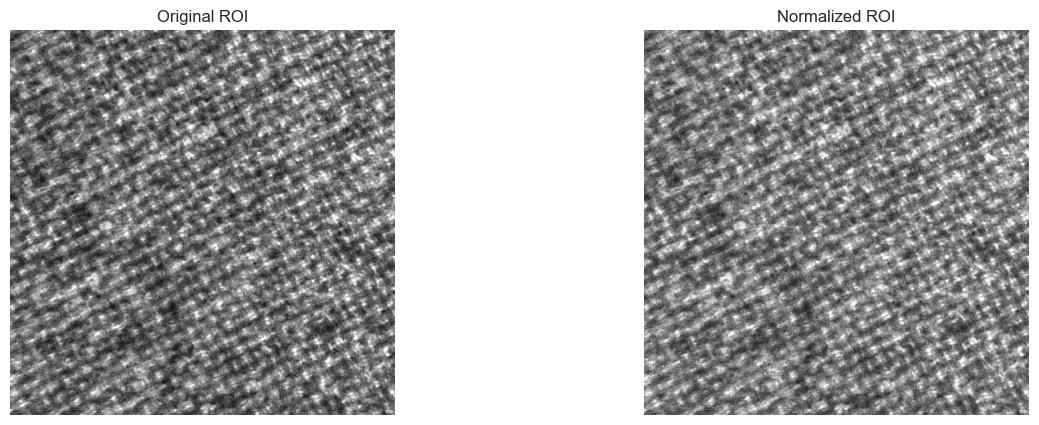

In [259]:
from PIL import Image

image = Image.open(DUMMY_PATH_2+'/blanket1-a-p001-r030.png')
w, h = image.size
mask = Image.new('RGB', (w, h), (255, 255, 255))
image_np = np.array(image)
mask_np = np.array(mask)

if len(image_np.shape) == 3 and image_np.shape[2] == 3:
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
else:
    image_gray = image_np 
    
if len(mask_np.shape) == 3 and mask_np.shape[2] == 3:
    mask_gray = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY)
else:
    mask_gray = mask_np 
    
print(image_gray.shape)
print(mask_gray.shape)
roi1d_norm, roi2d_norm = normalize_image_intensity(image_gray, mask_gray, resegment=False, k=7)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Original ROI')
ax[0].axis('off') 
ax[1].imshow(roi2d_norm, cmap='gray', vmin=0, vmax=127)
ax[1].set_title('Normalized ROI')
ax[1].axis('off') 

plt.show()

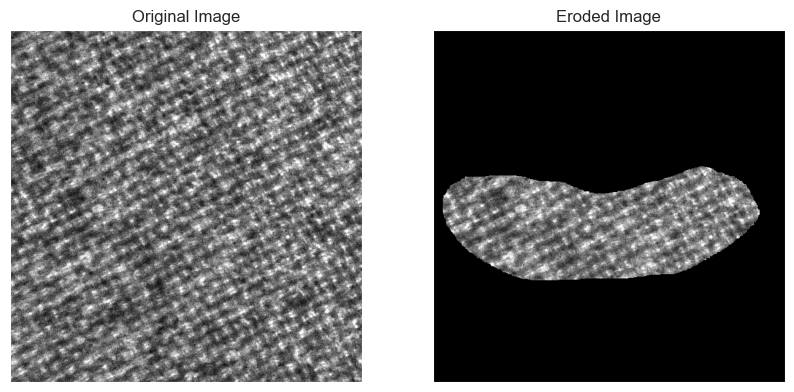

In [260]:
from PIL import Image

image = Image.open(DUMMY_PATH_2+'/blanket1-a-p001-r030.png')
mask_path = DUMMY_PATH_2+'/blanket1-a-p001-r030_mask.png'
mask = Image.open(mask_path)
image_np = np.array(image)
mask_np = np.array(mask)

if len(image_np.shape) == 3 and image_np.shape[2] == 3:
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
else:
    image_gray = image_np 
    
if len(mask_np.shape) == 3 and mask_np.shape[2] == 3:
    mask_gray = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY)
else:
    mask_gray = mask_np 

mask = erode_mask(mask_gray)
roi1d, roi2d = normalize_image_intensity(image_gray, mask, resegment=False, k=6)

plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(roi2d, cmap='gray')
plt.title('Eroded Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
from PIL import Image

def my_feature_extractor_dummy(input_csv, images_path, mask_png=False, normalized_image=False, k=8):
    """
    Creates the dataset with the features from the images 
    :param input_csv: csv with samples
    :param images_path: folder with images and masks
    :param mask_png: use the mask file
    :param normalized_image: if True normalize images with +/-3 sigma normalization
    :param k: k bits for quantification. Default 8.
    :return: dataframe with patient id, file, label and features
    """
   
    try:
        with open(input_csv, 'r') as inFile:
          cr = csv.DictReader(inFile, lineterminator='\n')
          cases = []
          for row_idx, row in enumerate(cr, start=1):
            cases.append(row)
    except Exception:
        logger.error('CSV READ FAILED', exc_info=True)
        
    feature_list = []    
    
    for case in cases:
         
        img_path = os.path.join(images_path, case['Image'])
        image = Image.open(img_path)
        if mask_png:
            mask_path = os.path.join(images_path, os.path.splitext(os.path.basename(img_path))[0] + '_mask.png')
            mask = Image.open(mask_path)
        else:
            w, h = image.size
            mask = Image.new('RGB', (w, h), (255, 255, 255))
                    
        image_np = np.array(image)
        mask_np = np.array(mask)
        
        if len(image_np.shape) == 3 and image_np.shape[2] == 3:
            image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        else:
            image_gray = image_np 
            
        if len(mask_np.shape) == 3 and mask_np.shape[2] == 3:
            mask_gray = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY)
        else:
            mask_gray = mask_np 
        
        if mask_png:
            mask_gray = erode_mask(mask_gray)
            
        if normalized_image:
            roi1d, roi2d = normalize_image_intensity(image_gray, mask_gray, resegment=False, k=k)
            
            if has_zero_values(roi1d):
                  roi2d_marked = mark_non_roi_pixels(roi2d, mask_gray)
                  features_glcm = glcm_features(roi2d_marked)
                  features_glrm = glrm_features(roi2d_marked)
            else:
                  features_glcm = glcm_features(roi2d)
                  features_glrm = glrm_features(roi2d)
            features_glh = glh_features(roi1d)
            features_lbp = lbp_features_extractor(roi2d, mask_gray)
        else:
            roi1d, roi2d = crop_image(image_gray, mask_gray)
            features_glcm = glcm_features(roi2d)
            features_glrm = glrm_features(roi2d)
            features_glh = glh_features(roi1d)
            features_lbp = lbp_features_extractor(roi2d, mask_gray)
        
    
        features = {**case, **features_glh, **features_glcm,  **features_glrm,  **features_lbp}
        feature_list.append(features)
              
    return pd.DataFrame(feature_list)

In [ ]:
blanket_stone = my_feature_extractor_dummy('../data/blanket_stone_samples.csv', DUMMY_PATH_2, False, False, k=7)

In [ ]:
blanket_stone.to_csv('../data/dummy/blanket_stone.csv', index=False)

In [ ]:
blanket_stone = my_feature_extractor_dummy('../data/blanket_stone_val_samples.csv', DUMMY_PATH_2, False, True, k=7)

In [ ]:
blanket_stone.to_csv('../data/dummy/blanket_stone_3sigma.csv', index=False)

In [ ]:
blanket_stone_val = my_feature_extractor_dummy('../data/blanket_stone_val_samples.csv', DUMMY_PATH_3, False, True, k=7)

In [ ]:
blanket_stone_val.to_csv('../data/dummy/blanket_stone_val_3sigma.csv', index=False)

In [ ]:
def get_size(mask_path, erode=True):
    """
    Converts image and mask to grey scale, validates shapes and minimum of ROI of 400 pixels
    :param mask_path: path to the mask file
    :param erode: if True erode mask
  
    :return: number of pixels
    """
   
    mask = Image.open(mask_path)
    mask_np = np.array(mask)
 
    if len(mask_np.shape) == 3 and mask_np.shape[2] == 3:
        mask_gray = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY)
    else:
        mask_gray = mask_np 
 
    if erode:
        mask_gray = erode_mask(mask_gray)
        
    roi_size = np.count_nonzero(mask_gray)

    return roi_size
    
def get_roi_sizes(input_csv, folder):
    """
    Add roi sizes to input_csv
    """ 
    try:
        with open(input_csv, 'r') as inFile:
          cr = csv.DictReader(inFile, lineterminator='\n')
          cases = []
          for row_idx, row in enumerate(cr, start=1):
            cases.append(row)
    except Exception:
        logger.error('CSV READ FAILED', exc_info=True)
        
       
    for case in cases:
         
         img_path = os.path.join(folder, case['Image'])
         mask_path = os.path.join(folder, os.path.splitext(os.path.basename(img_path))[0] + '_mask.png')
         size = get_size(mask_path)
         
         case['ROI pixels'] = size
 
    return pd.DataFrame(cases)

In [ ]:
new_df = get_roi_sizes('../data/sand_stone_samples.csv', DUMMY_PATH_1)
new_df.to_csv('../data/sand_stone_samples.csv', index=False)

In [ ]:
new_df = get_roi_sizes('../data/blanket_stone_samples.csv', DUMMY_PATH_2)
new_df.to_csv('../data/blanket_stone_samples.csv', index=False)

In [ ]:
new_df = get_roi_sizes('../data/blanket_stone_val_samples.csv', DUMMY_PATH_3)
new_df.to_csv('../data/blanket_stone_val_samples.csv', index=False)

In [ ]:
sand_stone = my_feature_extractor_dummy('../data/sand_stone_samples.csv', DUMMY_PATH_1, True, False)
sand_stone.to_csv('../data/dummy/sand_stone_mask.csv', index=False)

In [ ]:
sand_stone = my_feature_extractor_dummy('../data/sand_stone_samples.csv', DUMMY_PATH_1, True, True, k=7)
sand_stone.to_csv('../data/dummy/sand_stone_mask_3sigma.csv', index=False)

In [ ]:
blanket_stone = my_feature_extractor_dummy('../data/blanket_stone_samples.csv', DUMMY_PATH_2, True, False)
blanket_stone.to_csv('../data/dummy/blanket_stone_mask.csv', index=False)

In [ ]:
blanket_stone = my_feature_extractor_dummy('../data/blanket_stone_samples.csv', DUMMY_PATH_2, True, True, k=7)
blanket_stone.to_csv('../data/dummy/blanket_stone_mask_3sigma.csv', index=False)

In [ ]:
blanket_stone_val = my_feature_extractor_dummy('../data/blanket_stone_val_samples.csv', DUMMY_PATH_3, True, True, k=7)

In [ ]:
blanket_stone_val.to_csv('../data/dummy/blanket_stone_mask_val_3sigma.csv', index=False)

In [ ]:
df_blanket = pd.read_csv('../data/dummy/blanket_stone_mask_3sigma_norm_not_balanced.csv')
shuffled_df = df_blanket.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/dummy/blanket_stone_mask_3sigma_norm_not_balanced.csv', index=False)

In [ ]:
df_blanket = pd.read_csv('../data/dummy/blanket_stone_mask_val_3sigma_norm_not_balanced.csv')
shuffled_df = df_blanket.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('../data/dummy/blanket_stone_mask_val_3sigma_norm_not_balanced.csv', index=False)